
# 파일명: cnt_analysis.ipynb
# 작성자: 인현서 , 구경모
# 소속: 한양대학교 NISL Lab, Connectome-based olfactory AI (ADOnet) project
# 설명: Connectome-based MLP model(OSN->PN->KC) with DoOR data
# Input: Random vs DoOR
# Model: FC MLP vs Connectome (syn count 유무)


# Import tools and data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import copy
import torch._dynamo

from google.colab import drive
import os


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/adonet_data')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 작업 디렉토리: {os.getcwd()} 현재 디바이스: {device}")
pd.set_option('display.max_rows',    None)
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
현재 작업 디렉토리: /content/drive/MyDrive/adonet_data 현재 디바이스: cpu


In [ ]:

csv_path_door= ('door_imputed_same_perOSN_dist.csv')
doorset = pd.read_csv(csv_path_door)
print(doorset.shape)
doorset.head()

Connectome data 불러오기 / Syn Count 양수

In [ ]:
#csv_path_cnt= ('Olfactory_Connection.csv')
#cntset = pd.read_csv(csv_path_cnt)
#print(cntset.shape)
#cntset.head()

Connectome data 불러오기 / Syn Count 음수

In [ ]:
csv_path_cnt= ('Olfactory_Connection_NT.csv')
cntset = pd.read_csv(csv_path_cnt)
print(cntset.shape)
cntset.head()

DoOR data 불러오기 from 구경모

In [ ]:
csv_path_ann= ('DoOR_data.csv')
X_ann = pd.read_csv(csv_path_ann,index_col=0)
print(X_ann.shape)
X_ann.head()

# FeedForward dataset [for Mask process]

In [ ]:
ff=cntset[cntset["directionality"]=='feedforward']
print(ff[:5])


           pre_root_id        post_root_id  syn_count    pre_type  \
5   720575940602553568  720575940608304220          1  KCapbp-ap2   
16  720575940602553568  720575940612196850          1  KCapbp-ap2   
17  720575940602553568  720575940612455338          1  KCapbp-ap2   
36  720575940602553568  720575940617552340          7  KCapbp-ap2   
37  720575940602553568  720575940617760257          3  KCapbp-ap2   

      post_type pre_class post_class directionality  
5   MBON15-like        KC       MBON    feedforward  
16  MBON15-like        KC       MBON    feedforward  
17       MBON15        KC       MBON    feedforward  
36       MBON02        KC       MBON    feedforward  
37       MBON17        KC       MBON    feedforward  


# OR to PN dataset [for Mask process]

In [ ]:
otp=ff[(ff["pre_class"]=='ORN') & (ff["post_class"]=='ALPN')]
print(otp.shape)
print(otp[:5])
counts=otp["pre_root_id"].value_counts()
otp_cnt=len(counts.index)
otp_idx=counts.index
print(otp_idx)

(26239, 8)
             pre_root_id        post_root_id  syn_count pre_type  post_type  \
1914  720575940603356128  720575940606762686          4  ORN_DM2  M_l2PNl20   
1945  720575940603356128  720575940622192822          1  ORN_DM2  M_lvPNm25   
1947  720575940603356128  720575940622448166          1  ORN_DM2  M_lvPNm26   
1948  720575940603356128  720575940622793310          2  ORN_DM2  M_lvPNm25   
1961  720575940603356128  720575940628420008          1  ORN_DM2  M_lvPNm25   

     pre_class post_class directionality  
1914       ORN       ALPN    feedforward  
1945       ORN       ALPN    feedforward  
1947       ORN       ALPN    feedforward  
1948       ORN       ALPN    feedforward  
1961       ORN       ALPN    feedforward  
Index([720575940628599296, 720575940608376132, 720575940636767856,
       720575940622745834, 720575940625583204, 720575940616783361,
       720575940620303732, 720575940613118610, 720575940613664874,
       720575940645728132,
       ...
       7205759406

In [ ]:
counts=otp["post_root_id"].value_counts()
otp_cnt2=len(counts.index)
otp_idx2=counts.index
print(otp_idx2)

Index([720575940606762686, 720575940631683927, 720575940628200506,
       720575940618615360, 720575940640639293, 720575940606757041,
       720575940638288447, 720575940618855344, 720575940624057853,
       720575940631930828,
       ...
       720575940615270545, 720575940627245585, 720575940614774923,
       720575940628514647, 720575940628504919, 720575940637749574,
       720575940624695629, 720575940630275269, 720575940633688275,
       720575940623673802],
      dtype='int64', name='post_root_id', length=615)


# PN to KC dataset  [for Mask process]

In [ ]:
ptk=ff[(ff['pre_class']=='ALPN') & (ff['post_class']=='KC')]
print(ptk.shape)
counts=ptk["pre_root_id"].value_counts()
ptk_cnt=len(counts.index)
ptk_idx=counts.index
print(ptk_idx)

(29343, 8)
Index([720575940618308825, 720575940622726271, 720575940637056887,
       720575940619071005, 720575940630770042, 720575940621529435,
       720575940615366055, 720575940609460491, 720575940623528925,
       720575940611079236,
       ...
       720575940627353426, 720575940627244986, 720575940615255993,
       720575940614326162, 720575940613613619, 720575940613058802,
       720575940612468594, 720575940631633401, 720575940632720026,
       720575940633356883],
      dtype='int64', name='pre_root_id', length=334)


In [ ]:
counts=ptk["post_root_id"].value_counts()
ptk_cnt2=len(counts.index)
ptk_idx2=counts.index
print(ptk_idx2)

Index([720575940606892674, 720575940623546638, 720575940625175845,
       720575940620684014, 720575940629127936, 720575940629074540,
       720575940646602372, 720575940610618341, 720575940629792620,
       720575940628808186,
       ...
       720575940621576063, 720575940621997921, 720575940624153608,
       720575940624164104, 720575940645209966, 720575940629803264,
       720575940620576494, 720575940616677661, 720575940606666953,
       720575940633023935],
      dtype='int64', name='post_root_id', length=4907)


# Select Model 1, A. MASK with [no syn count weight] [for Mask process]

In [ ]:
otp_unique = otp[['pre_root_id','post_root_id']]
mask_otp_norm = pd.crosstab(
    index=otp_unique['pre_root_id'],    # 행: ORN ID
    columns=otp_unique['post_root_id']  # 열: ALPN ID
)

mask_otp = torch.from_numpy(mask_otp_norm.T.values).float().to(device)  # (615, 2278)
print(mask_otp.shape)
print(mask_otp)

#mask_otp_norm.T.to_csv('mask_otp.csv', index=True)

torch.Size([615, 2278])
tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
alpn_ids=mask_otp_norm.columns

ptk_unique=ptk[['pre_root_id', 'post_root_id']]
mask_ptk_norm = (
    pd.crosstab(
        index=ptk_unique['pre_root_id'],    # ALPN ID (334종)
        columns=ptk_unique['post_root_id'], # KC ID
    )
    .reindex(index=alpn_ids,   # 여기에 615개 ALPN ID 전체 지정
             fill_value=0)      # 없는 ALPN은 모두 0으로
)
mask_ptk = torch.from_numpy(mask_ptk_norm.T.values).float().to(device)  # (4907,334)
print(mask_ptk.shape)
print(mask_ptk)

#mask_ptk_norm.T.to_csv('mask_ptk.csv', index = True)

torch.Size([4907, 615])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Weight 초기화에 kaiming(he) 사용했음. 약 +-0.051

In [ ]:
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, mask):
        super().__init__()
        # weight, bias 호출, 계산을 위함
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        self.bias   = nn.Parameter(torch.zeros(out_features))

        nn.init.kaiming_uniform_(self.weight, nonlinearity='relu')      #Kaiming(He) 방식의 가중치 초기화
        #with torch.no_grad():
            #self.weight.mul_(1000)  # **여기서 weight에 1000배 곱해줌**
        # mask는 학습 가중치가 아닌 buffer니까
        self.register_buffer('mask', mask.float())

    def forward(self, x):
        # weight에 mask를 곱해서, mask==0인 부분은 항상 0이 되도록
        w = self.weight * self.mask
        return torch.nn.functional.linear(x, w, self.bias)



# Select Model 1, B. MASK with [syn count weight] [for Mask process]

In [ ]:
otp_unique = otp[['pre_root_id','post_root_id']]
mask_otp_norm = pd.crosstab(
    index=otp_unique['pre_root_id'],    # 행: ORN ID
    columns=otp_unique['post_root_id']  # 열: ALPN ID
    , values=otp['syn_count']           # syn count 값
    , aggfunc='sum'                     # 없어도 되긴함
    ).fillna(0)                         #나머지 NaN = 0 처리

mask_otp = torch.from_numpy(mask_otp_norm.T.values).float().to(device)  # (615, 2278)
mask_otp_origin = copy.deepcopy(mask_otp_norm.T)
print(mask_otp_origin.shape)
mask_otp_norm.head()

#mask_otp_norm.T.to_csv('mask_otp_NT.csv', index=True)

(615, 2278)


post_root_id        720575940603231916  720575940603446374  \
pre_root_id                                                  
720575940603356128                 0.0                 0.0   
720575940603430112                 0.0                 0.0   
720575940603659488                 0.0                 0.0   
720575940603828704                 0.0                 0.0   
720575940603832288                 0.0                 0.0   

post_root_id        720575940603453286  720575940603464672  \
pre_root_id                                                  
720575940603356128                 0.0                 0.0   
720575940603430112                 0.0                 0.0   
720575940603659488                 0.0                 0.0   
720575940603828704                 0.0                 0.0   
720575940603832288                 0.0                 0.0   

post_root_id        720575940603985952  720575940604352172  \
pre_root_id                                                  
720575940603356128                 0.0                 0.0   
720575940603430112                 0.0                 0.0   
720575940603659488                 0.0                 0.0   
720575940603828704                 0.0                 0.0   
720575940603832288                 0.0                 1.0   

post_root_id        720575940604407468  720575940604412588  \
pre_root_id                                                  
720575940603356128                 0.0                 0.0   
720575940603430112                 0.0                 0.0   
720575940603659488                 0.0                 0.0   
720575940603828704                 0.0                 0.0   
720575940603832288                 0.0                 0.0   

post_root_id        720575940604418988  720575940604431584  \
pre_root_id                                                  
720575940603356128                 0.0                 0.0   
720575940603430112                 0.0                 0.0   
720575940603659488                 0.0                 0.0   
720575940603828704                 0.0                 0.0   
720575940603832288                 0.0                 0.0   

post_root_id        720575940604624574  720575940604911793  \
pre_root_id                                                  
720575940603356128                 0.0                 0.0   
720575940603430112                 0.0                 0.0   
720575940603659488                 0.0                 0.0   
720575940603828704                 0.0                 0.0   
720575940603832288                 0.0                 0.0   

post_root_id        720575940604919473  720575940604974978  \
pre_root_id                                                  
720575940603356128                 0.0                 0.0   
720575940603430112                 0.0                 0.0   
720575940603659488                 0.0                 0.0   
720575940603828704                 0.0                 0.0   
720575940603832288                 0.0                 0.0   

post_root_id        720575940604985265  720575940605102694  \
pre_root_id                                                  
720575940603356128                 0.0                 0.0   
720575940603430112                 0.0                 0.0   
720575940603659488                 0.0                 0.0   
720575940603828704                 0.0                 0.0   
720575940603832288                 0.0                 0.0   

post_root_id        720575940605309361  720575940605391794  \
pre_root_id                                                  
720575940603356128                 0.0                 0.0   
720575940603430112                 0.0                 0.0   
720575940603659488                 0.0                 0.0   
720575940603828704                 0.0                 0.0   
720575940603832288                 0.0                 0.0   

post_root_id        720575940605400096  720575940605421442  \
pre_root_id            

In [ ]:
#otp_ids = mask_otp_norm.rows
alpn_ids=mask_otp_norm.columns
#kc_ids = mask_ptk_norm.columns

ptk_unique=ptk[['pre_root_id', 'post_root_id']]
mask_ptk_norm = (
    pd.crosstab(
        index=ptk_unique['pre_root_id'],    # ALPN ID (334종)
        columns=ptk_unique['post_root_id'], # KC ID
        values=ptk['syn_count'],
        aggfunc='sum'
    )
    .reindex(index=alpn_ids,   # 여기에 615개 ALPN ID 전체 지정
             fill_value=0)      # 없는 ALPN은 모두 0으로
    .fillna(0)                  #나머지 NaN = 0 처리
)
mask_ptk = torch.from_numpy(mask_ptk_norm.T.values).float().to(device)  # (4907,334)
mask_ptk_origin = copy.deepcopy(mask_ptk_norm.T)
print(mask_ptk_origin.shape)
print(torch.unique(mask_ptk))

#mask_ptk_norm.T.to_csv('mask_ptk_NT.csv', index = True)

(4907, 615)
tensor([-22., -18., -16., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
         -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
          9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
         21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
         45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
         58.,  60.,  62.,  63.,  68.,  69.,  70.,  78.])


In [ ]:
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, weight):
        super().__init__()
        self.weight = nn.Parameter(weight)
        self.bias   = nn.Parameter(torch.zeros(out_features))
        self.register_buffer('mask', torch.sign(weight).float())    # +1/-1/0 weight의 부호만 살려서 mask에 저장

    def forward(self, x):
        # weight의 절댓값만 학습, 부호는 mask로 고정해서 weight의 부호가 바뀌면서 output 부호가 음수에서 양수가 되는 경우를 방지
        w = torch.abs(self.weight) * self.mask
        # Use functional linear transformation
        return torch.nn.functional.linear(x, w, self.bias)

# MAX 정규화


In [ ]:
def normalize_by_max_(x):
    y=x/x.max()
    return y
mask_otp_n=normalize_by_max_(mask_otp)
mask_ptk_n=normalize_by_max_(mask_ptk)


# Select Model 1. Connectome Model [for Mask process]

In [ ]:
class DC_odor_classifier(nn.Module):
  def __init__(self,input_dim,output_dim, mask1, mask2):
    super().__init__()
    self.net=nn.Sequential(
        MaskedLinear(input_dim,615, mask1),
        nn.ReLU(),
        MaskedLinear(615,4907, mask2),
        nn.ReLU(),
        nn.Linear(4907,output_dim)
    )
  def forward(self, x):
    return self.net(x)
model=DC_odor_classifier(2278,250,mask_otp,mask_ptk).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
print(torch.unique(model.net[0].weight))
print(model.net[0].mask)

tensor([-32., -28., -25., -19., -17., -16., -13., -12.,  -8.,  -6.,  -5.,  -3.,
         -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
         10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
         34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
         46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
         58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
         70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,
         82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
         94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
        106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117.,
        118., 119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
        130., 131., 132., 133., 134., 13

In [ ]:
print(torch.unique(model.net[2].weight))
print(model.net[2].mask)

tensor([-22., -18., -16., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
         -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
          9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
         21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
         45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
         58.,  60.,  62.,  63.,  68.,  69.,  70.,  78.],
       grad_fn=<Unique2Backward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
otp_random_origin = copy.deepcopy((model.net[0].weight*model.net[0].mask).detach())
ptk_random_origin = copy.deepcopy((model.net[2].weight*model.net[2].mask).detach())

In [ ]:
otp_random_origin.max().max()

tensor(327.)

# Select Model 2. Simple MLP Model [for FC-Layer MLP]

In [ ]:
n_classes=250
class Rndodor(nn.Module):
  def __init__(self,input_dim,output_dim):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(input_dim,615),
        nn.ReLU(),
        nn.Linear(615,4907),
        nn.ReLU(),
        nn.Linear(4907,output_dim)
    )
  def forward(self, x):
    return self.net(x)

model=Rndodor(2278,250).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train / Test
# Select Input 1. DoOR data input

In [ ]:
cls_labels = []
for i in range(250):
  cls_labels.append(f'Odor_({i+1})')

print(len(cls_labels))
print(cls_labels[:5])
print(cls_labels[245:])


250
['Odor_(1)', 'Odor_(2)', 'Odor_(3)', 'Odor_(4)', 'Odor_(5)']
['Odor_(246)', 'Odor_(247)', 'Odor_(248)', 'Odor_(249)', 'Odor_(250)']


In [ ]:
le=LabelEncoder()
y_int=le.fit_transform(cls_labels)
y = y_int
print(le.classes_[:5])
y_out=torch.tensor(y,dtype=torch.long)
print(y_out[:5])
print(y_out.shape)

['Odor_(1)' 'Odor_(10)' 'Odor_(100)' 'Odor_(101)' 'Odor_(102)']
tensor([  0, 111, 173, 184, 195])
torch.Size([250])


In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

idx=torch.randint(0,250,(1000,))
#idx = torch.arange(250).repeat(4)         # 0~249가 4번씩 (길이 1000)
#idx = idx[torch.randperm(1000)]            # 랜덤으로 섞음

for n in idx:
  noise=torch.normal(mean=0,std=0.2,size=(2278,))

  xi=X_ann.iloc[n.item()] # Convert tensor to scalar and use .iloc for integer-based indexing
  xn  = torch.zeros(2278, dtype=torch.float32)
  xn=torch.tensor(xi.values, dtype=torch.float32)+noise # Convert pandas Series to tensor
  x_train.append(xn)
  y_train.append(y_out[n]) # Append the individual element y_out[n]

idx=torch.randint(0,250,(200,))

for k in idx:
  noise=torch.normal(mean=0,std=0.2,size=(2278,))

  xi=X_ann.iloc[k.item()] # Convert tensor to scalar and use .iloc for integer-based indexing
  xn  = torch.zeros(2278, dtype=torch.float32)
  xn=torch.tensor(xi.values, dtype=torch.float32)+noise # Convert pandas Series to tensor
  x_test.append(xn)
  y_test.append(y_out[k]) # Append the individual element y_out[k]

In [ ]:
x_train = torch.stack(x_train).to(dtype=torch.float32)
y_train = torch.stack(y_train).to(dtype=torch.long)
x_test = torch.stack(x_test).to(dtype=torch.float32)
y_test = torch.stack(y_test).to(dtype=torch.long)

train_ds = TensorDataset(x_train, y_train)
test_ds  = TensorDataset(x_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

# Train / Test
# Select Input 2. Random prototype Input

In [ ]:
cls_labels = []
for i in range(250):
  cls_labels.append(f'Odor_({i+1})')

print(len(cls_labels))
print(cls_labels[:5])
print(cls_labels[245:])


250
['Odor_(1)', 'Odor_(2)', 'Odor_(3)', 'Odor_(4)', 'Odor_(5)']
['Odor_(246)', 'Odor_(247)', 'Odor_(248)', 'Odor_(249)', 'Odor_(250)']


In [ ]:
le=LabelEncoder()
y_int=le.fit_transform(cls_labels)
y = y_int
print(le.classes_[:5])
y_out=torch.tensor(y,dtype=torch.long)
print(y_out[:5])
print(y_out.shape)

['Odor_(1)' 'Odor_(10)' 'Odor_(100)' 'Odor_(101)' 'Odor_(102)']
tensor([  0, 111, 173, 184, 195])
torch.Size([250])


In [ ]:
xp = torch.rand(250,53,dtype=torch.float32)
print(xp[1][:])


tensor([0.3407, 0.3373, 0.5293, 0.9427, 0.3236, 0.7109, 0.6932, 0.7104, 0.1436,
        0.7050, 0.6697, 0.6021, 0.1305, 0.8043, 0.6610, 0.5896, 0.8237, 0.5359,
        0.5810, 0.9995, 0.3517, 0.1809, 0.4804, 0.7188, 0.9535, 0.4804, 0.3327,
        0.0516, 0.5096, 0.2659, 0.9263, 0.1101, 0.0776, 0.5379, 0.0890, 0.0232,
        0.9822, 0.8216, 0.8294, 0.5231, 0.7181, 0.0554, 0.5003, 0.4491, 0.6172,
        0.8078, 0.2611, 0.7318, 0.6438, 0.5460, 0.1340, 0.3029, 0.5476])


In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

idx=torch.randint(0,250,(1000,))
#idx = torch.arange(250).repeat(4)         # 0~249가 4번씩 (길이 1000)
#idx = idx[torch.randperm(1000)]            # 랜덤으로 섞음


for n in idx:
  noise=torch.normal(mean=0,std=0.2,size=(43,53))

  xi=xp[n]
  xn  = torch.zeros(43,53, dtype=torch.float32)
  xn=(xi+noise).flatten()

  xn=xn[1:]

  x_train.append(xn)
  y_train.append(y_out[n]) # Append the individual element y_out[n]

In [ ]:
idx=torch.randint(0,250,(200,))

for k in idx:
  noise=torch.normal(mean=0,std=0.2,size=(43,53))

  xi=xp[k]
  xn  = torch.zeros(43,53, dtype=torch.float32)
  xn=(xi+noise).flatten()

  xn=xn[1:]

  x_test.append(xn)
  y_test.append(y_out[k]) # Append the individual element y_out[k]

In [ ]:
x_train = torch.stack(x_train).to(dtype=torch.float32)
y_train = torch.stack(y_train).to(dtype=torch.long)
x_test = torch.stack(x_test).to(dtype=torch.float32)
y_test = torch.stack(y_test).to(dtype=torch.long)

train_ds = TensorDataset(x_train, y_train)
test_ds  = TensorDataset(x_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

# Learn & Result

In [ ]:
from tqdm.auto import trange
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy

num_epochs = 1000
train_losses, train_accs = [], []

for epoch in trange(num_epochs, desc="Epochs"):
    model.train()
    tr_loss = tr_acc = 0.0
    y_true = []
    y_pred = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        # 누적 loss/acc 계산
        tr_loss += loss.item() * xb.size(0)
        tr_acc  += (logits.argmax(dim=1) == yb).float().sum().item()

        # CM용 값
        y_true.append(yb.cpu())
        y_pred.append(logits.argmax(dim=1).cpu())

    tr_loss /= len(train_loader.dataset)
    tr_acc  /= len(train_loader.dataset)
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)

    print(f"Epoch {epoch+1:02d}/{num_epochs}  "
          f"Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4%}  ")





Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 01/1000  Train Loss: 5.5205, Acc: 0.7000%  
Epoch 02/1000  Train Loss: 5.5136, Acc: 1.7000%  
Epoch 03/1000  Train Loss: 5.5052, Acc: 2.3000%  
Epoch 04/1000  Train Loss: 5.4921, Acc: 2.4000%  
Epoch 05/1000  Train Loss: 5.4719, Acc: 2.2000%  
Epoch 06/1000  Train Loss: 5.4436, Acc: 1.9000%  
Epoch 07/1000  Train Loss: 5.4056, Acc: 1.6000%  
Epoch 08/1000  Train Loss: 5.3592, Acc: 1.5000%  
Epoch 09/1000  Train Loss: 5.3063, Acc: 1.5000%  
Epoch 10/1000  Train Loss: 5.2512, Acc: 1.5000%  
Epoch 11/1000  Train Loss: 5.1936, Acc: 1.6000%  
Epoch 12/1000  Train Loss: 5.1342, Acc: 1.8000%  
Epoch 13/1000  Train Loss: 5.0719, Acc: 2.4000%  
Epoch 14/1000  Train Loss: 5.0058, Acc: 2.6000%  
Epoch 15/1000  Train Loss: 4.9320, Acc: 4.6000%  
Epoch 16/1000  Train Loss: 4.8520, Acc: 8.1000%  
Epoch 17/1000  Train Loss: 4.7616, Acc: 12.1000%  
Epoch 18/1000  Train Loss: 4.6652, Acc: 15.5000%  
Epoch 19/1000  Train Loss: 4.5583, Acc: 20.8000%  
Epoch 20/1000  Train Loss: 4.4439, Acc: 24.4000

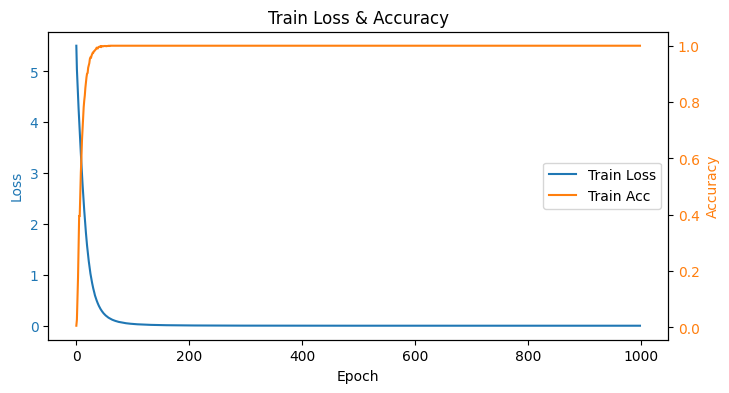

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# Loss: 왼쪽 y축
ax1.plot(train_losses, color='tab:blue', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Accuracy: 오른쪽 y축
ax2 = ax1.twinx()
ax2.plot(train_accs, color='tab:orange', label='Train Acc')
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right')

plt.title('Train Loss & Accuracy')
plt.show()


In [ ]:
model.eval()
te_correct = 0
total_samples = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        te_correct += (logits.argmax(dim=1) == yb).float().sum().item()
        total_samples += xb.size(0)
test_acc = te_correct / total_samples
print(f"Test set accuracy: {test_acc:.4%}")


Test set accuracy: 94.0000%


# PCA 3D plot

In [ ]:
alpn_ids=otp["post_root_id"].unique()
alpn_ids.sort()
print(len(alpn_ids))

kc_ids=ptk["post_root_id"].unique()
kc_ids.sort()
print(len(kc_ids))

615
4907


In [ ]:
# alpn, kc layer output 추출 모델 정의 및 인덱스 정의
def layer_output_extract(model, x):
  alpn_output = model.net[0](x)
  alpn_output_relu = model.net[1](alpn_output)
  kc_output = model.net[2](alpn_output_relu)
  kc_output_relu = model.net[3](kc_output)
  return alpn_output,alpn_output_relu , kc_output, kc_output_relu


Random Input for PCA

In [ ]:
n_odor = 250
n_feat = 2278

# 1. 0~1 uniform random base (odor별 1개씩 250개)
base_vals = np.random.uniform(0, 1, n_odor)

# 2. 각 odor에 대해, 평균 0, std 0.2 노이즈(2278차원) 생성
random_data = np.zeros((n_odor, n_feat))
for i, base in enumerate(base_vals):
    noise = np.random.normal(0, 0.2, n_feat)
    random_data[i, :] = base + noise  # 250 x 2278 random input


random_df = pd.DataFrame(random_data, index=np.arange(n_odor))
random_tensor = torch.tensor(random_df.values, dtype=torch.float32).to(device)


ALPN_output, ALPN_output_relu, KC_output, KC_output_relu = layer_output_extract(model, random_tensor)
alpn_df = pd.DataFrame(ALPN_output.cpu().detach().numpy(), index=random_df.index, columns=alpn_ids)
alpn_relu_df = pd.DataFrame(ALPN_output_relu.cpu().detach().numpy(), index=random_df.index, columns=alpn_ids)
kc_df = pd.DataFrame(KC_output.cpu().detach().numpy(), index=random_df.index, columns=kc_ids)
kc_relu_df = pd.DataFrame(KC_output_relu.cpu().detach().numpy(), index=random_df.index, columns=kc_ids)


DoOR Input for PCA

In [ ]:
door_data_csv= ('/content/drive/My Drive/Colab Notebooks/connectome/DoOR_data.csv')
door_data=pd.read_csv(door_data_csv,index_col=0)
door_data_tensor = torch.tensor(door_data.values, dtype=torch.float32).to(device)


ALPN_output,ALPN_output_relu ,KC_output, KC_output_relu = layer_output_extract(model,door_data_tensor)


#y_train 숫자 smell로 매치
y_train = y_train.cpu().detach().numpy()
DoOR_data = doorset
DoOR_idx = DoOR_data.iloc[:, 0]
smell=[]
for idx in y_train:
    smell.append(DoOR_idx[idx])
print(len(smell))

#torch에서 numpy로
ALPN_output = ALPN_output.cpu().detach().numpy()
ALPN_output_relu = ALPN_output_relu.cpu().detach().numpy()
KC_output = KC_output.cpu().detach().numpy()
KC_output_relu = KC_output_relu.cpu().detach().numpy()

#nympy에서 pandas로
alpn_df = pd.DataFrame(ALPN_output,index = door_data.index ,columns=alpn_ids)
alpn_relu_df = pd.DataFrame(ALPN_output_relu,index = door_data.index ,columns=alpn_ids)
kc_df = pd.DataFrame(KC_output,index = door_data.index ,columns=kc_ids)
kc_relu_df = pd.DataFrame(KC_output_relu,index = door_data.index ,columns=kc_ids)

1000


In [ ]:
print(torch.unique(torch.tensor(alpn_df.values)))

tensor([0.0000e+00, 2.8600e-05, 5.7200e-05,  ..., 4.2229e+03, 4.3052e+03,
        4.5124e+03])


/tmp/ipython-input-90-3470041393.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


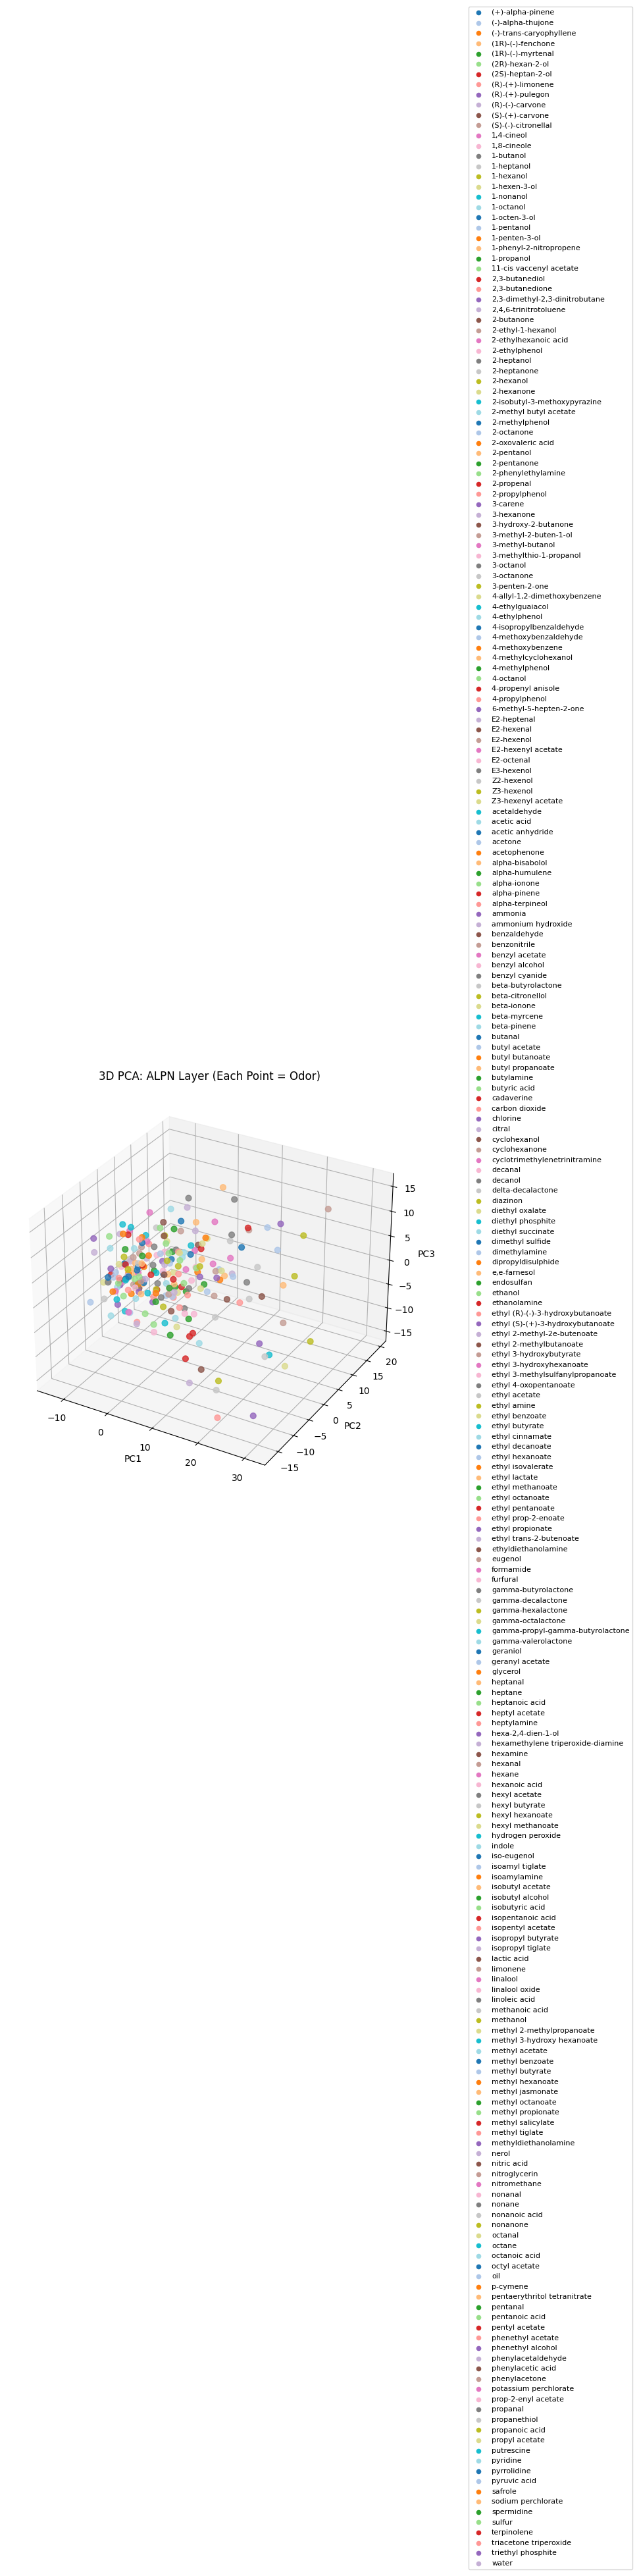

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D 플롯을 위해 필요

# 1. 데이터 준비
labels = alpn_relu_df.index.to_numpy()  # 각 odor 이름 (index가 냄새라면)
X = alpn_relu_df.values                # feature matrix

# 2. (선택) 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)   # (샘플수, 3)

# 4. 색상(혹은 마커) 지정 (odor 이름별로 다르게)
# 예시: unique label별 색상 자동 할당

unique_labels = np.unique(labels)
label_to_color = {name: plt.cm.tab20(i % 20) for i, name in enumerate(unique_labels)}
colors = [label_to_color[l] for l in labels]

# 5. 3D 플롯
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=colors, s=40, alpha=0.8)

# 6. 범례 추가
for name in unique_labels:
    ax.scatter([], [], [], color=label_to_color[name], label=name)
ax.legend(loc='center left', bbox_to_anchor=(1.13, 0.5), ncol=1, fontsize=8)
plt.subplots_adjust(right=0.85)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA: ALPN Layer (Each Point = Odor)')
plt.tight_layout()
plt.show()

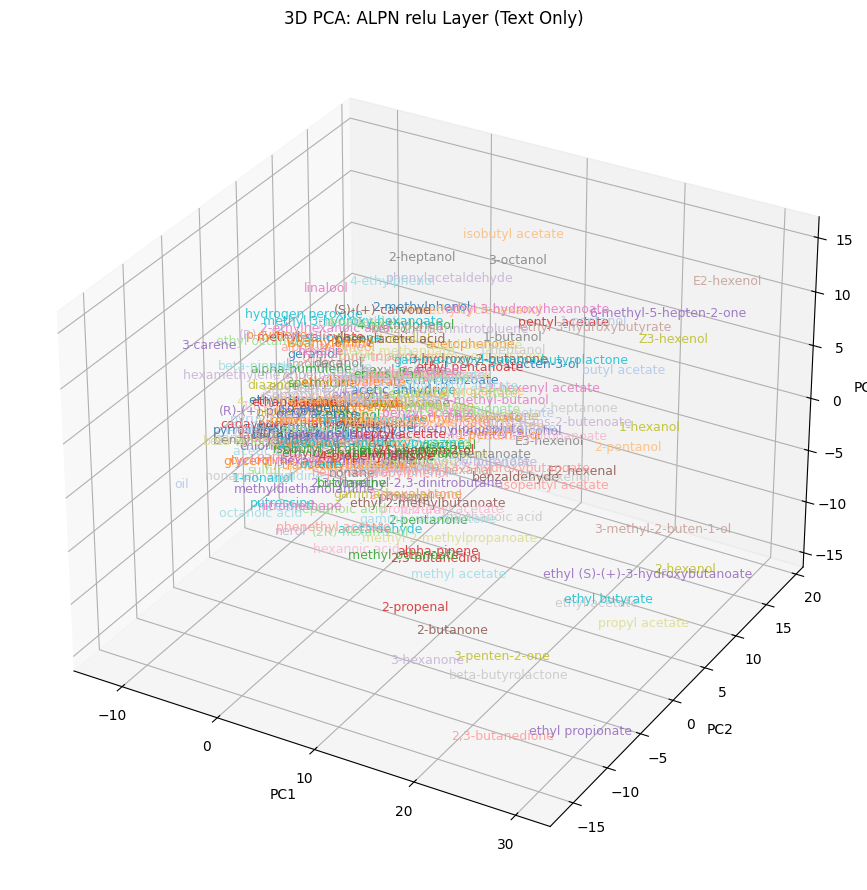

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 데이터 준비
labels = alpn_relu_df.index.to_numpy()  # 각 odor 이름 (index가 냄새라면)
X = alpn_relu_df.values                # feature matrix

# 2. 정규화 (선택)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)   # (샘플수, 3)

# 4. 색상 지정 (odor별 색깔)
unique_labels = np.unique(labels)
label_to_color = {name: plt.cm.tab20(i % 20) for i, name in enumerate(unique_labels)}
colors = [label_to_color[l] for l in labels]

# 5. 축 범위 계산
x_min, x_max = X_pca[:,0].min(), X_pca[:,0].max()
y_min, y_max = X_pca[:,1].min(), X_pca[:,1].max()
z_min, z_max = X_pca[:,2].min(), X_pca[:,2].max()

# (조금 더 여유를 주고 싶다면 아래처럼!)
x_pad = (x_max - x_min) * 0.05
y_pad = (y_max - y_min) * 0.05
z_pad = (z_max - z_min) * 0.05

# 6. 3D 플롯 (점 없이 텍스트만)
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

for i, odor in enumerate(labels):
    ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], str(odor),
            size=9, color=colors[i], alpha=0.85)

ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)
ax.set_zlim(z_min - z_pad, z_max + z_pad)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA: ALPN relu Layer (Text Only)')
plt.tight_layout()
plt.show()


/tmp/ipython-input-92-634716329.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


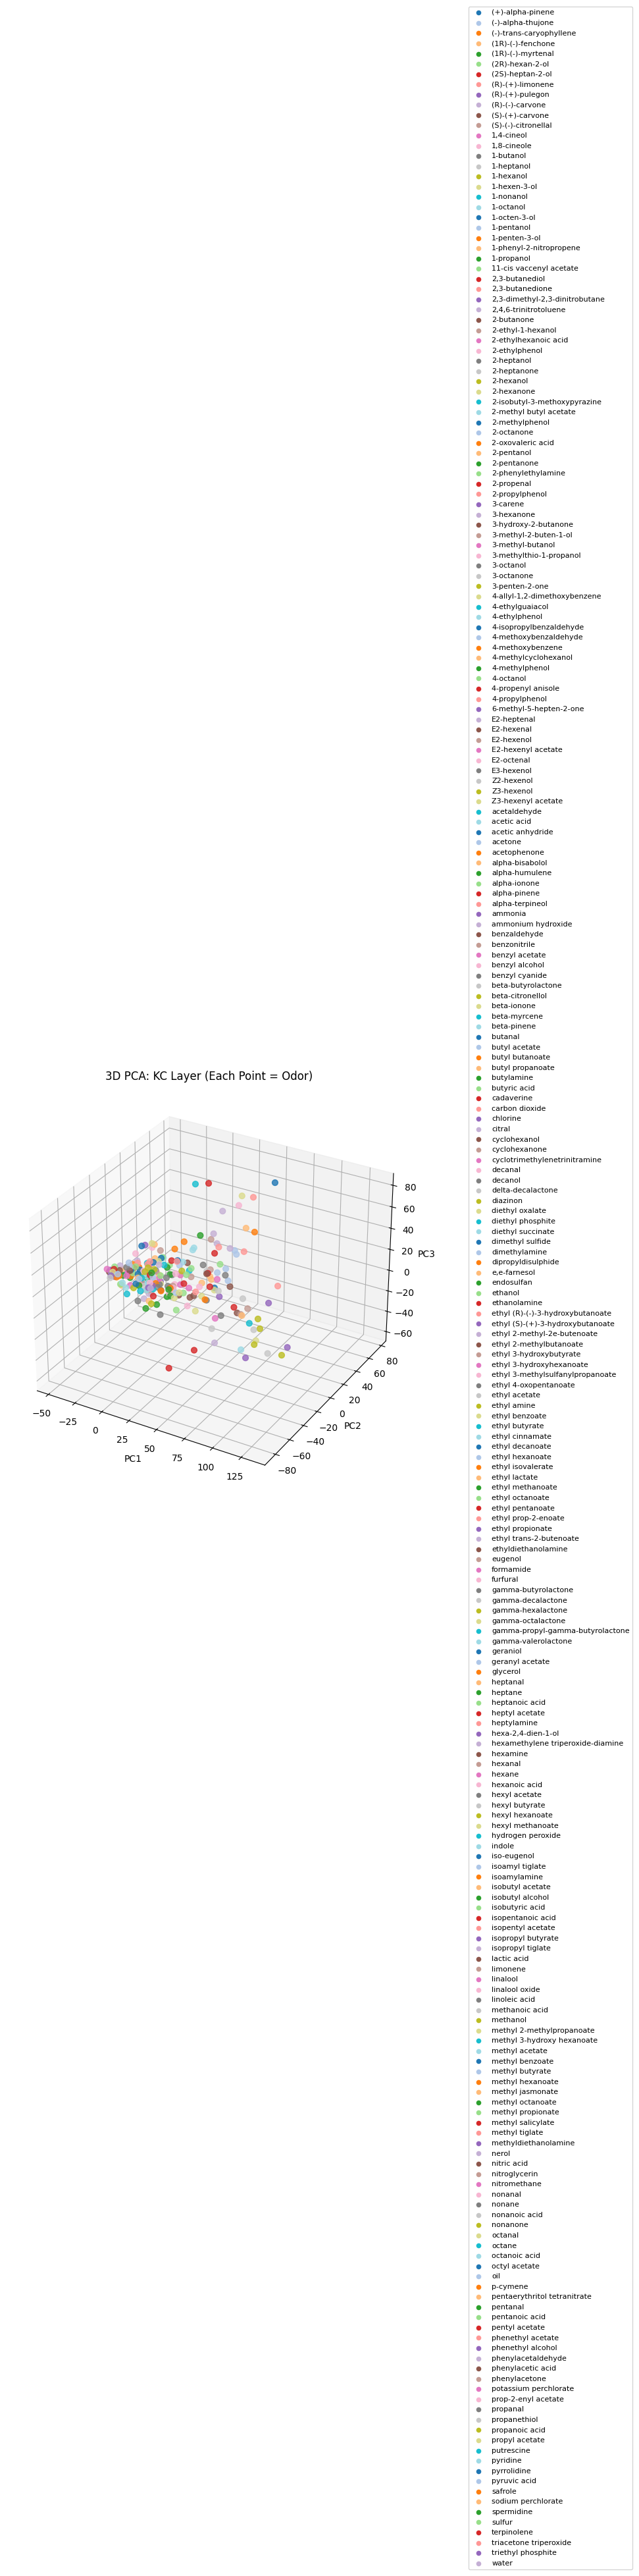

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D 플롯을 위해 필요

# 1. 데이터 준비
labels = kc_relu_df.index.to_numpy()  # 각 odor 이름 (index가 냄새라면)
X = kc_relu_df.values                # feature matrix

# 2. (선택) 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)   # (샘플수, 3)

# 4. 색상(혹은 마커) 지정 (odor 이름별로 다르게)
# 예시: unique label별 색상 자동 할당

unique_labels = np.unique(labels)
label_to_color = {name: plt.cm.tab20(i % 20) for i, name in enumerate(unique_labels)}
colors = [label_to_color[l] for l in labels]

# 5. 3D 플롯
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=colors, s=40, alpha=0.8)

# 6. 범례 추가
for name in unique_labels:
    ax.scatter([], [], [], color=label_to_color[name], label=name)
ax.legend(loc='center left', bbox_to_anchor=(1.13, 0.5), ncol=1, fontsize=8)
plt.subplots_adjust(right=0.85)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA: KC Layer (Each Point = Odor)')
plt.tight_layout()
plt.show()

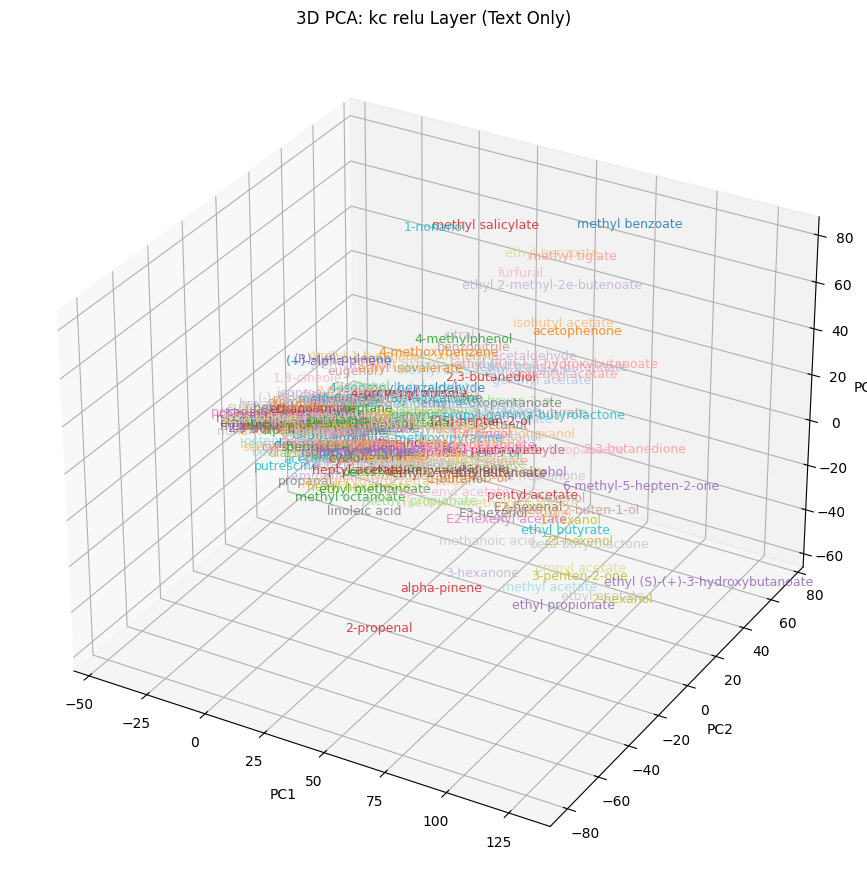

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 데이터 준비
labels = kc_relu_df.index.to_numpy()  # 각 odor 이름 (index가 냄새라면)
X = kc_relu_df.values                # feature matrix

# 2. 정규화 (선택)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)   # (샘플수, 3)

# 4. 색상 지정 (odor별 색깔)
unique_labels = np.unique(labels)
label_to_color = {name: plt.cm.tab20(i % 20) for i, name in enumerate(unique_labels)}
colors = [label_to_color[l] for l in labels]

# 5. 축 범위 계산
x_min, x_max = X_pca[:,0].min(), X_pca[:,0].max()
y_min, y_max = X_pca[:,1].min(), X_pca[:,1].max()
z_min, z_max = X_pca[:,2].min(), X_pca[:,2].max()

# (조금 더 여유를 주고 싶다면 아래처럼!)
x_pad = (x_max - x_min) * 0.05
y_pad = (y_max - y_min) * 0.05
z_pad = (z_max - z_min) * 0.05

# 6. 3D 플롯 (점 없이 텍스트만)
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

for i, odor in enumerate(labels):
    ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], str(odor),
            size=9, color=colors[i], alpha=0.85)

ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)
ax.set_zlim(z_min - z_pad, z_max + z_pad)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA: kc relu Layer (Text Only)')
plt.tight_layout()
plt.show()


In [ ]:
alpn_df.to_csv('alpn_output.csv')
alpn_relu_df.to_csv('alpn_output_relu.csv')
kc_df.to_csv('kc_output.csv')
kc_relu_df.to_csv('kc_output_relu.csv')

# t-sne


In [ ]:
alpn_ids=otp["post_root_id"].unique()
alpn_ids.sort()
print(len(alpn_ids))

kc_ids=ptk["post_root_id"].unique()
kc_ids.sort()
print(len(kc_ids))

615
4907


In [ ]:
# alpn, kc layer output 추출 모델 정의 및 인덱스 정의
def layer_output_extract(model, x):
  alpn_output = model.net[0](x)
  alpn_output_relu = model.net[1](alpn_output)
  kc_output = model.net[2](alpn_output_relu)
  kc_output_relu = model.net[3](kc_output)
  return alpn_output,alpn_output_relu , kc_output, kc_output_relu

In [ ]:
door_data_csv= ('DoOR_data.csv')
door_data=pd.read_csv(door_data_csv,index_col=0)
door_data_tensor = torch.tensor(door_data.values, dtype=torch.float32).to(device)


ALPN_output,ALPN_output_relu ,KC_output, KC_output_relu = layer_output_extract(model,x_train.to(device))

In [ ]:
#y_train 숫자 smell로 매치
y_train = y_train.cpu().detach().numpy()
DoOR_data = doorset
DoOR_idx = DoOR_data.iloc[:, 0]
smell=[]
for idx in y_train:
    smell.append(DoOR_idx[idx])
print(len(smell))


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
#torch에서 numpy로
ALPN_output = ALPN_output.cpu().detach().numpy()
ALPN_output_relu = ALPN_output_relu.cpu().detach().numpy()
KC_output = KC_output.cpu().detach().numpy()
KC_output_relu = KC_output_relu.cpu().detach().numpy()

#nympy에서 pandas로
alpn_df = pd.DataFrame(ALPN_output,index = smell ,columns=alpn_ids)
alpn_relu_df = pd.DataFrame(ALPN_output_relu,index = smell ,columns=alpn_ids)
kc_df = pd.DataFrame(KC_output,index = smell ,columns=kc_ids)
kc_relu_df = pd.DataFrame(KC_output_relu,index = smell ,columns=kc_ids)

In [ ]:
!pip install openTSNE
!pip install --upgrade openTSNE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits


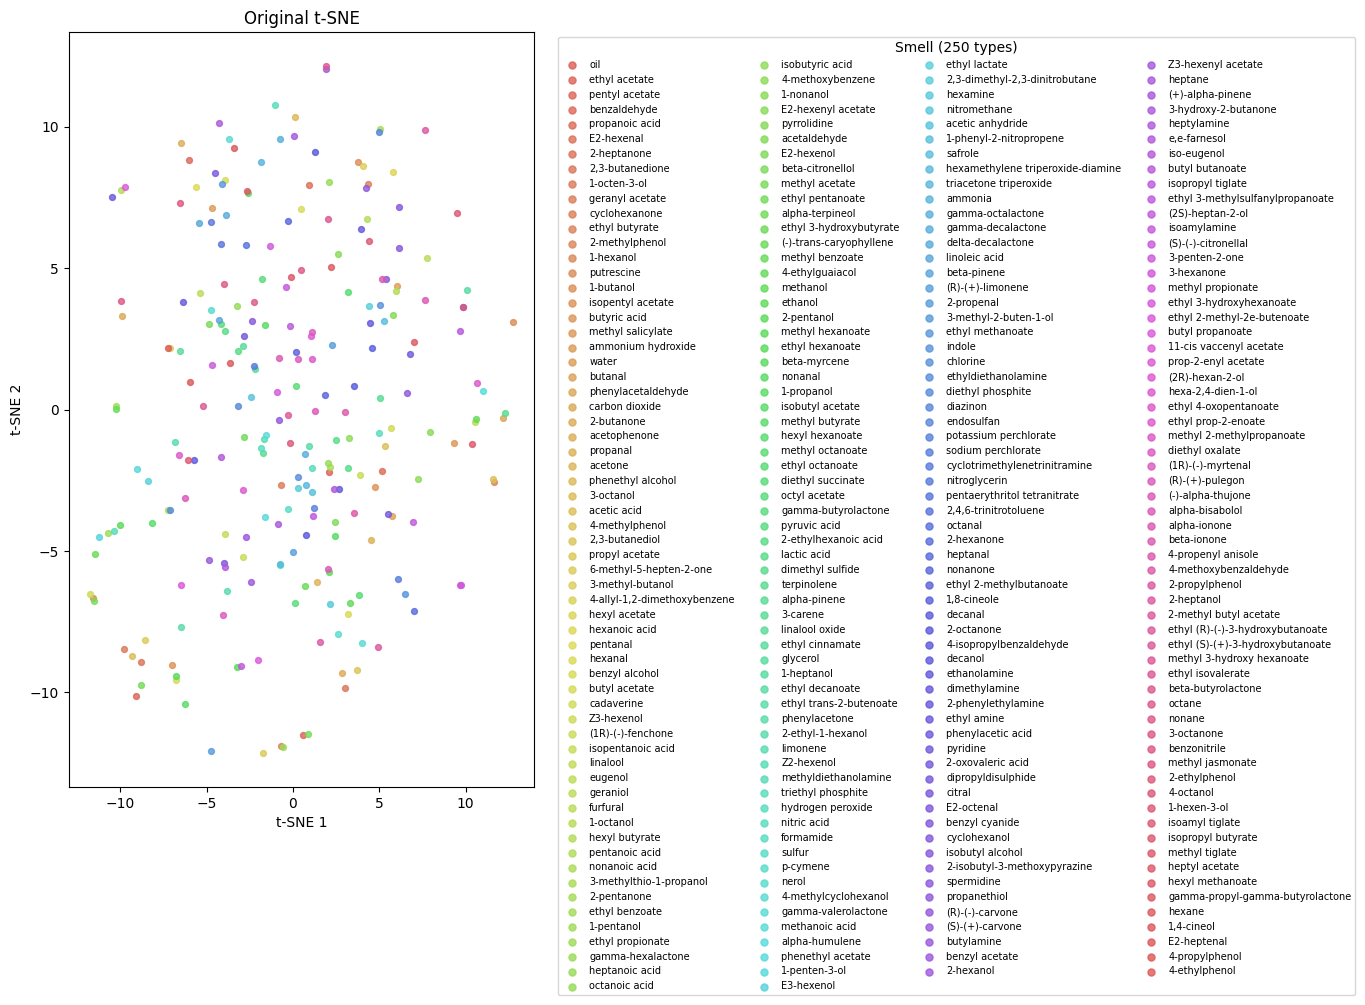

In [ ]:
#이름으로 원본데이터
original_data=pd.read_csv('door_imputed_same_perOSN_dist.csv',index_col=0)
#door=original_data.fillna('other')

features = original_data.loc[:, :'Or45a'].values
smell_names = original_data.index.values

le = LabelEncoder()
smell_labels = le.fit_transform(smell_names)
n_smells = len(le.classes_)

original_tsne = TSNE(n_components=2, random_state=42).fit_transform(features)
palette = sns.color_palette('hls', n_colors=n_smells)

plt.figure(figsize=(14, 10))

for i in range(n_smells):
    plt.scatter(
        original_tsne[i,0] , original_tsne[i,1], s=18, color = palette[i], label = original_data.index[i], alpha = 0.8
    )

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Original t-SNE')
plt.legend(
    bbox_to_anchor=(1.04, 1), loc='upper left',
    title='Smell (250 types)', fontsize=7, markerscale=1.2, ncol=4
)
plt.tight_layout()
plt.show()

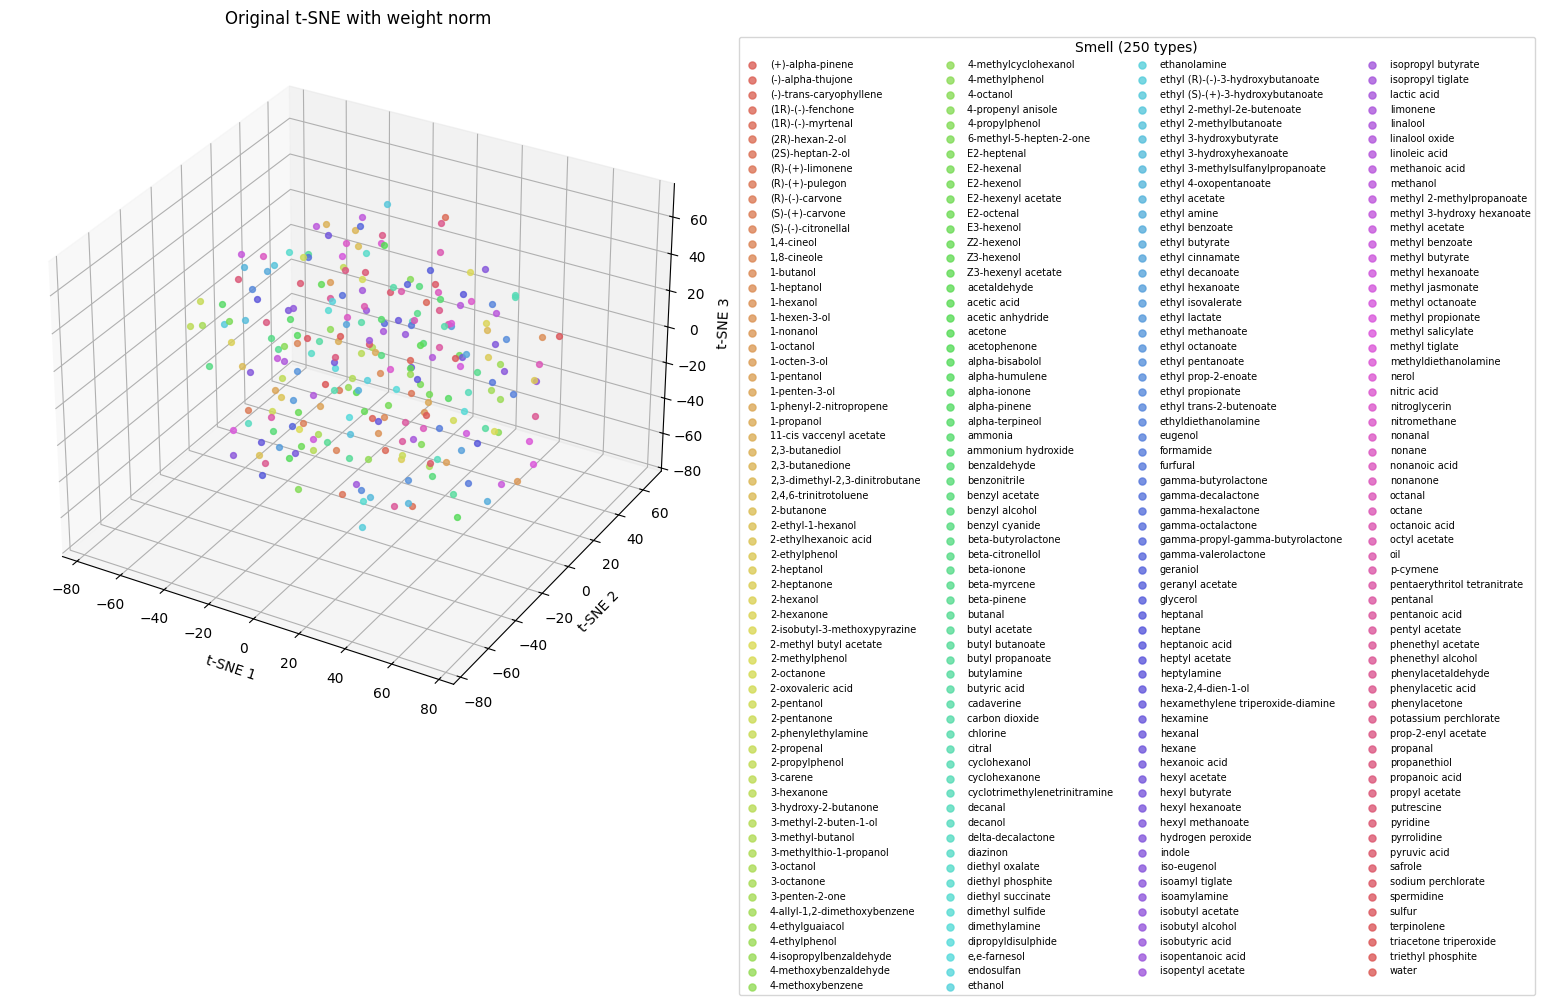

In [ ]:
#타입으로 원본데이터
original_data=pd.read_csv('DoOR_data.csv',index_col=0) #첫번째열 index로 하고싶으면 해야됨 첫번째행은 자동으로 인덱스 지정해주지만 열은 안해줌
door=original_data.fillna('other')

features = original_data.loc[:, :'Or45a'].values  # 행은 전체행
smell_types = original_data.index

le = LabelEncoder()
smell_labels = le.fit_transform(smell_types)
t_smells = len(le.classes_)

original_tsne = TSNE(n_components=3, random_state=42).fit_transform(features)
palette = sns.color_palette('hls', n_colors=t_smells)

fig = plt.figure(figsize=(14, 10)) # Create a figure
ax = fig.add_subplot(111, projection='3d') # Add a 3D subplot


for i, smtype in enumerate(le.classes_):
    mask = (smell_labels == i)
    ax.scatter( # Use ax.scatter for 3D plots
        original_tsne[mask,0] , original_tsne[mask,1],original_tsne[mask,2] , s=18, color = palette[i], label = smtype, alpha = 0.8
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3') # Add z-label for 3D plot
plt.title('Original t-SNE with weight norm')
ax.legend(
    bbox_to_anchor=(1.04, 1), loc='upper left',
    title='Smell (250 types)', fontsize=7, markerscale=1.2, ncol=4
)
plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

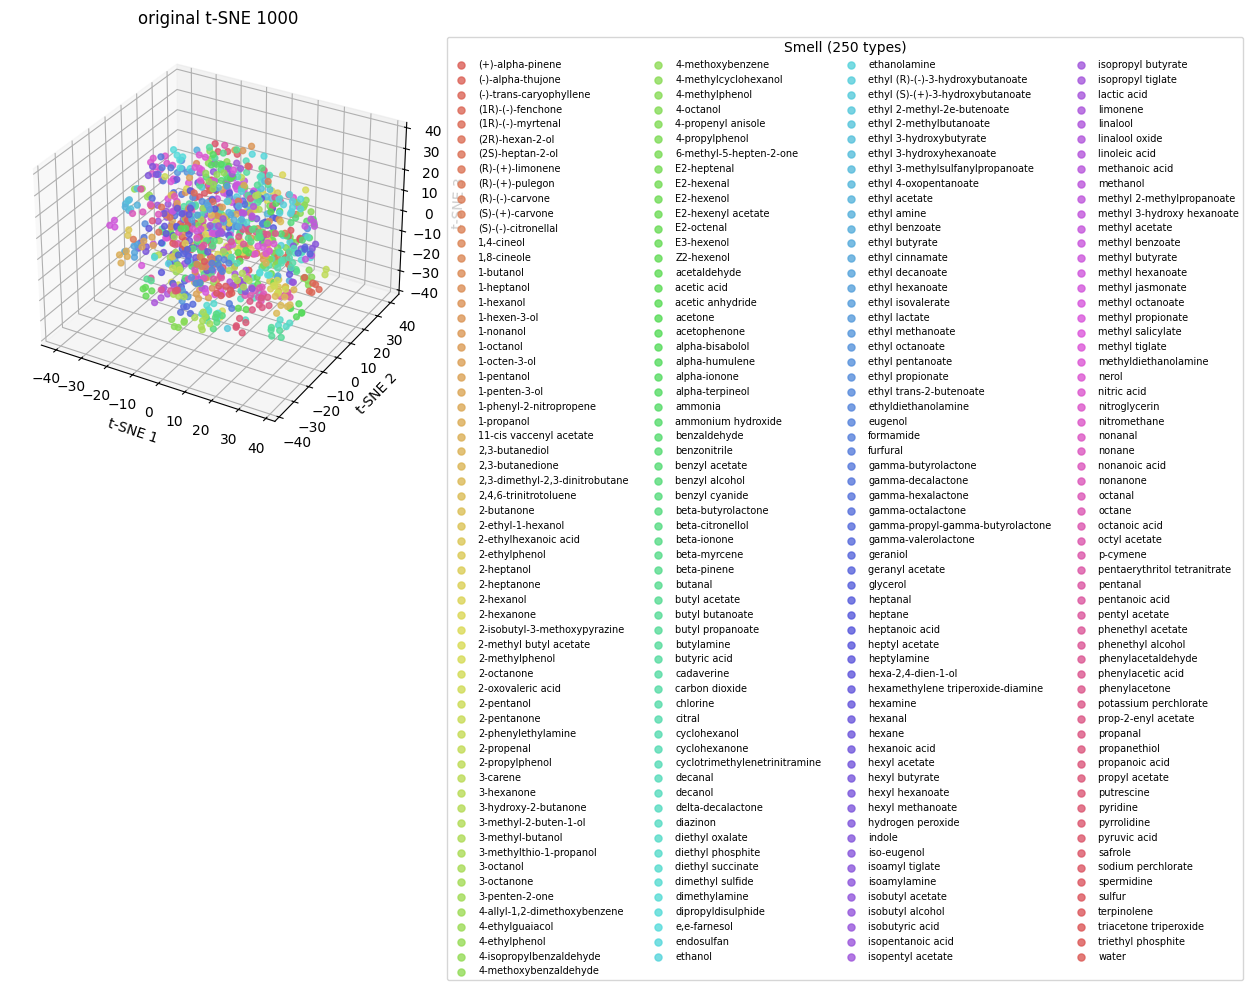

In [ ]:
# x_train data tsne
door_data=pd.read_csv('DoOR_data.csv',index_col=0) #첫번째열 index로 하고싶으면 해야됨 첫번째행은 자동으로 인덱스 지정해주지만 열은 안해줌
orn_ids=otp["pre_root_id"].unique()
orn_ids.sort()

smell_types = []
for i in y_train:
    smell_types.append(door_data.index[i])

x_train1 = x_train.cpu().detach().numpy()
x_train_df = pd.DataFrame(x_train1,index = smell_types ,columns=orn_ids)
features = x_train_df.values

le = LabelEncoder()
smell_labels = le.fit_transform(smell_types)
n_smells = len(le.classes_)

alpn_tsne = TSNE(n_components=3, random_state=42).fit_transform(features)
palette = sns.color_palette('hls', n_colors=n_smells)  # 250가지 고유색

plt.figure(figsize=(14, 10))

# Need a 3D projection for the plot
ax = plt.figure(figsize=(12, 8)).add_subplot(111, projection='3d')


for i, ctype in enumerate(le.classes_):
    mask = (smell_labels == i)
    ax.scatter(
        alpn_tsne[mask, 0], alpn_tsne[mask, 1], alpn_tsne[mask,2], # Added comma here
        s=18, color=palette[i], label= ctype, alpha=0.8
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3') # Added z-label for 3D plot
plt.title('original t-SNE 1000')
ax.legend(
    bbox_to_anchor=(1.04, 1), loc='upper left',
    title='Smell (250 types)', fontsize=7, markerscale=1.2, ncol=4
)
plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

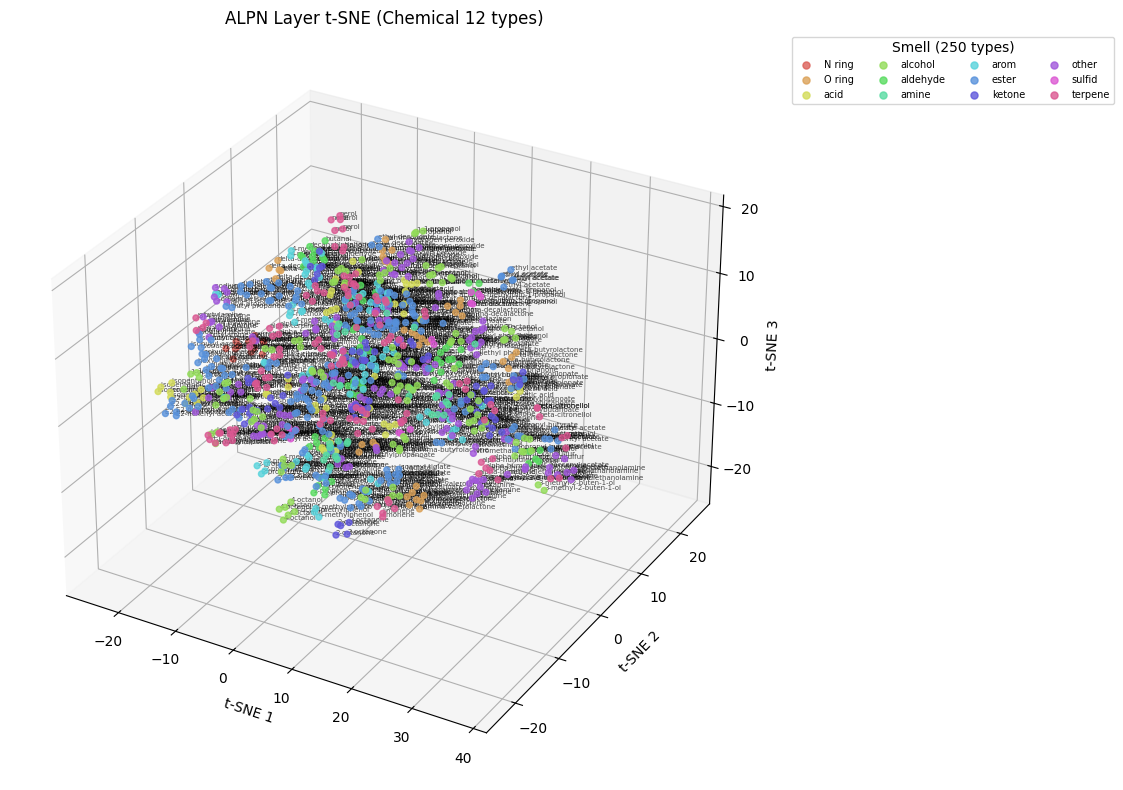

In [ ]:
# chemical type alpn output t-sne
original_data1=pd.read_csv('door_imputed_same_perOSN_dist.csv') #첫번째열 index로 하고싶으면 해야됨 첫번째행은 자동으로 인덱스 지정해주지만 열은 안해줌
door=original_data1.fillna('other')
features = alpn_relu_df.values
#smell_names = kc_df.index.values

smell_types = []
for i in y_train:
    smell_types.append(door.loc[i,'className'])

le = LabelEncoder()
smell_labels = le.fit_transform(smell_types)
n_smells = len(le.classes_)

alpn_tsne = TSNE(n_components=3, random_state=42).fit_transform(features)
palette = sns.color_palette('hls', n_colors=n_smells)  # 250가지 고유색

plt.figure(figsize=(14, 10))

# Need a 3D projection for the plot
ax = plt.figure(figsize=(12, 8)).add_subplot(111, projection='3d')


for i, ctype in enumerate(le.classes_):
    mask = (smell_labels == i)
    ax.scatter(
        alpn_tsne[mask, 0], alpn_tsne[mask, 1], alpn_tsne[mask,2], # Added comma here
        s=18, color=palette[i], label= ctype, alpha=0.8
    )

for idx in range(alpn_tsne.shape[0]):
    ax.text(
        alpn_tsne[idx, 0],
        alpn_tsne[idx, 1],
        alpn_tsne[idx, 2],
        door.iloc[y_train[idx],0],
        fontsize=5, alpha=0.7
    )
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3') # Added z-label for 3D plot
plt.title('ALPN Layer t-SNE (Chemical 12 types)')
ax.legend(
    bbox_to_anchor=(1.04, 1), loc='upper left',
    title='Smell (250 types)', fontsize=7, markerscale=1.2, ncol=4
)
plt.tight_layout()
plt.show()

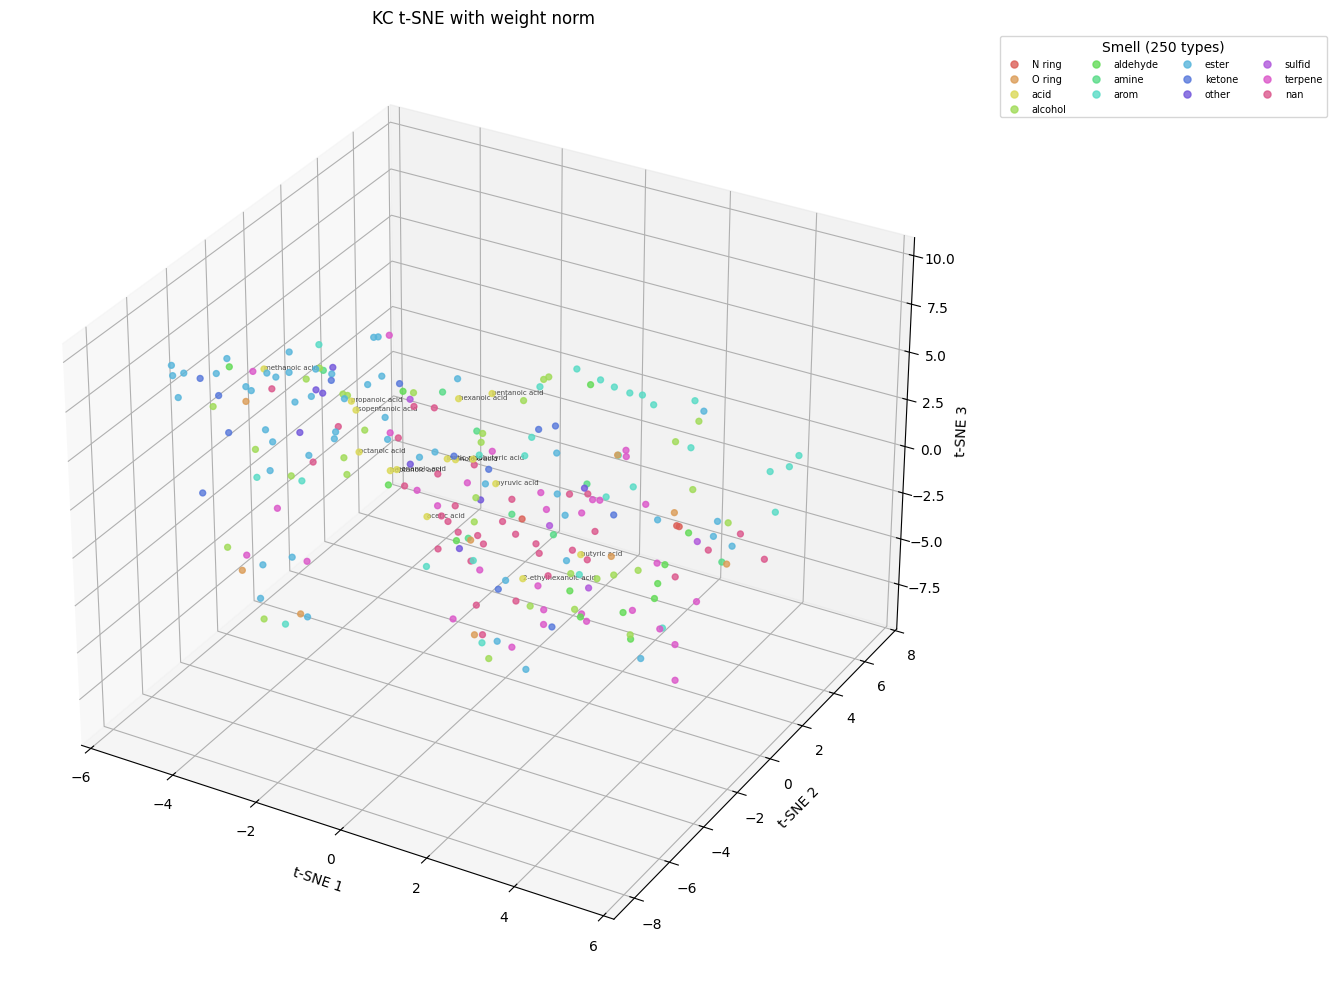

In [ ]:
# kc 250개 데이터 weight 정규화하고 이름으로 t-sne
original_data=pd.read_csv('DoOR_data.csv',index_col=0)
door_data = torch.tensor(original_data.values, dtype=torch.float32).to(device)
ALPN_output,ALPN_output_relu ,KC_output, KC_output_relu =layer_output_extract(model,door_data.to(device))
KC_output = KC_output.cpu().detach().numpy()
kc_df = pd.DataFrame(KC_output,index = original_data.index ,columns=kc_ids)

original_data2=pd.read_csv('door_imputed_same_perOSN_dist.csv', index_col = 'className') #첫번째열 index로 하고싶으면 해야됨 첫번째행은 자동으로 인덱스 지정해주지만 열은 안해줌
door=original_data.fillna('other')

features = kc_df.values  # 행은 전체행
smell_names = original_data2.index

le = LabelEncoder()
smell_labels = le.fit_transform(smell_names)
t_smells = len(le.classes_)

original_tsne = TSNE(n_components=3, random_state=42).fit_transform(features)
palette = sns.color_palette('hls', n_colors=t_smells)

fig = plt.figure(figsize=(14, 10)) # Create a figure
ax = fig.add_subplot(111, projection='3d') # Add a 3D subplot


for i, smtype in enumerate(le.classes_):
    mask = (smell_labels == i)
    ax.scatter( # Use ax.scatter for 3D plots
        original_tsne[mask,0] , original_tsne[mask,1],original_tsne[mask,2] , s=18, color = palette[i], label = smtype, alpha = 0.8
    )

#for idx in range(alpn_tsne.shape[0]):
#    ax.text(
#        original_tsne[idx, 0],
#        original_tsne[idx, 1],
#        original_tsne[idx, 2],
#        kc_df.index[idx],
#        fontsize=5, alpha=0.7
#    )

selected_classes = [ 'acid']  # 예시 smell class
for i, smtype in enumerate(le.classes_):
    mask = (smell_labels == i)
    if smtype in selected_classes:
        for idx in np.where(mask)[0]:
            ax.text(
                original_tsne[idx, 0],
                original_tsne[idx, 1],
                original_tsne[idx, 2],
                kc_df.index[idx],
                fontsize=5, alpha=0.7
            )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3') # Add z-label for 3D plot
plt.title('KC t-SNE with weight norm')
ax.legend(
    bbox_to_anchor=(1.04, 1), loc='upper left',
    title='Smell (250 types)', fontsize=7, markerscale=1.2, ncol=4
)
plt.tight_layout()
plt.show()

In [ ]:
# alpn 250개 데이터 weight 정규화하고 이름으로 t-sne
original_data=pd.read_csv('DoOR_data.csv',index_col=0)
door_data = torch.tensor(original_data.values, dtype=torch.float32).to(device)
ALPN_output,ALPN_output_relu ,KC_output, KC_output_relu =layer_output_extract(model,door_data.to(device))

ALPN_output_relu = ALPN_output_relu.cpu().detach().numpy()
alpn_df = pd.DataFrame(ALPN_output_relu,index = original_data.index ,columns=alpn_ids)

features = alpn_df.values  # 행은 전체행
smell_names = original_data.index

le = LabelEncoder()
smell_labels = le.fit_transform(smell_names)
t_smells = len(le.classes_)

original_tsne = TSNE(n_components=3, random_state=42).fit_transform(features)
palette = sns.color_palette('hls', n_colors=t_smells)

fig = plt.figure(figsize=(14, 10)) # Create a figure
ax = fig.add_subplot(111, projection='3d') # Add a 3D subplot


for i, smtype in enumerate(le.classes_):
    mask = (smell_labels == i)
    ax.scatter( # Use ax.scatter for 3D plots
        original_tsne[mask,0] , original_tsne[mask,1],original_tsne[mask,2] , s=18, color = palette[i], label = smtype, alpha = 0.8
    )
for idx in range(alpn_tsne.shape[0]):
    ax.text(
        alpn_tsne[idx, 0],
        alpn_tsne[idx, 1],
        alpn_tsne[idx, 2],
        door.iloc[y_train[idx],0],
        fontsize=6, alpha=0.7
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3') # Add z-label for 3D plot
plt.title('ALPN t-SNE with weight norm')
ax.legend(
    bbox_to_anchor=(1.04, 1), loc='upper left',
    title='Smell (250 types)', fontsize=7, markerscale=1.2, ncol=4
)
plt.tight_layout()
plt.show()

ValueError: Index className invalid

In [ ]:
ALPN_output,ALPN_output_relu ,KC_output, KC_output_relu = layer_output_extract(model,x_train.to(device))
#y_train 숫자 smell로 매치

DoOR_data = doorset
DoOR_idx = DoOR_data.iloc[:, 0]
smell=[]
for idx in y_train:
    smell.append(DoOR_idx[idx])
print(len(smell))

KC_output = KC_output.cpu().detach().numpy()
kc_df = pd.DataFrame(KC_output,index = smell ,columns=kc_ids)

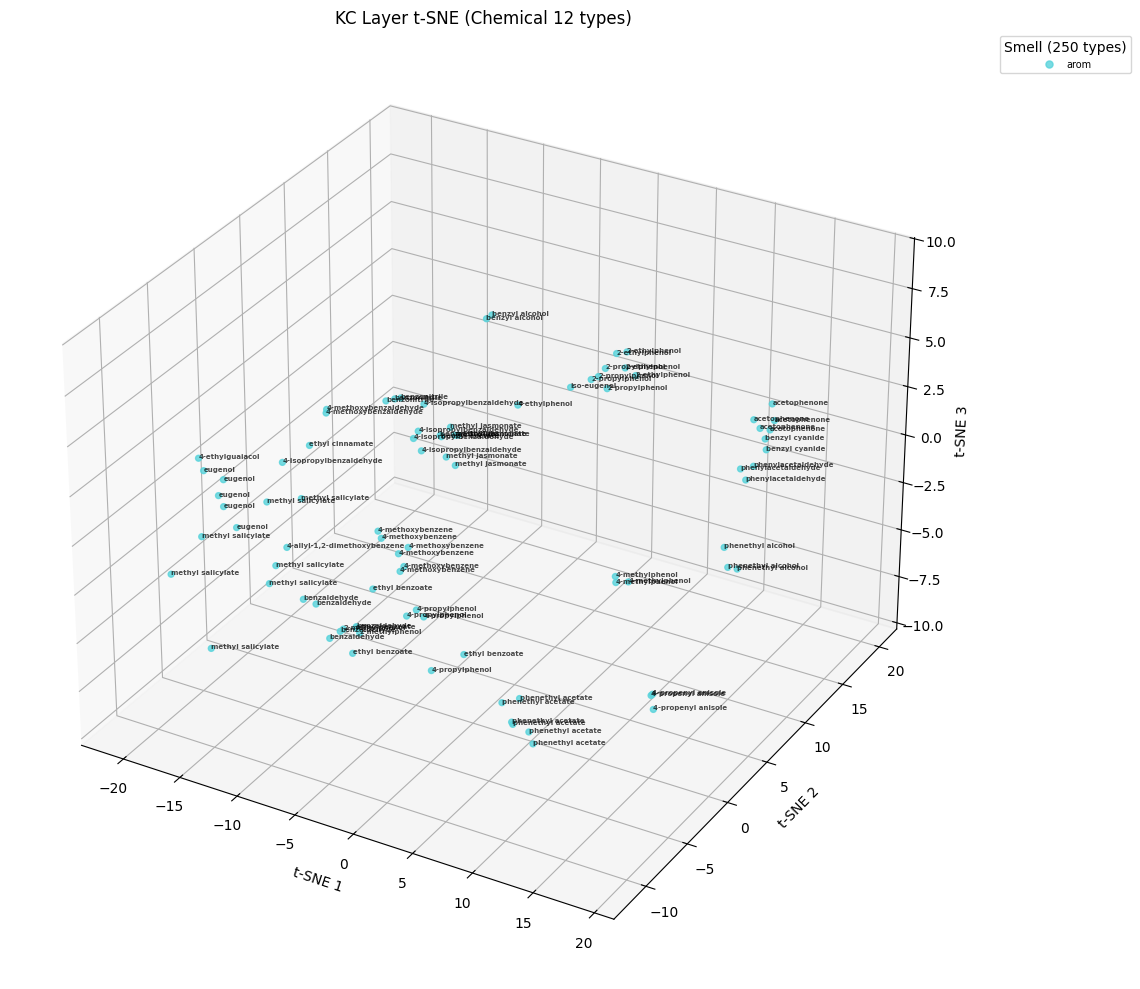

In [ ]:
# chemical type kc output t-sne with train data
original_data=pd.read_csv('door_imputed_same_perOSN_dist.csv') #첫번째열 index로 하고싶으면 해야됨 첫번째행은 자동으로 인덱스 지정해주지만 열은 안해줌
door=original_data.fillna('other')
features = kc_relu_df.values
#smell_names = kc_df.index.values

smell_types = []
for i in y_train:
    smell_types.append(door.iloc[i]['className'])

le = LabelEncoder()
smell_labels = le.fit_transform(smell_types)
n_smells = len(le.classes_)

# Since this is a 3D plot, n_components should be 3
kc_tsne = TSNE(n_components=3, random_state=42).fit_transform(features)
palette = sns.color_palette('hls', n_colors=n_smells)  # 250가지 고유색



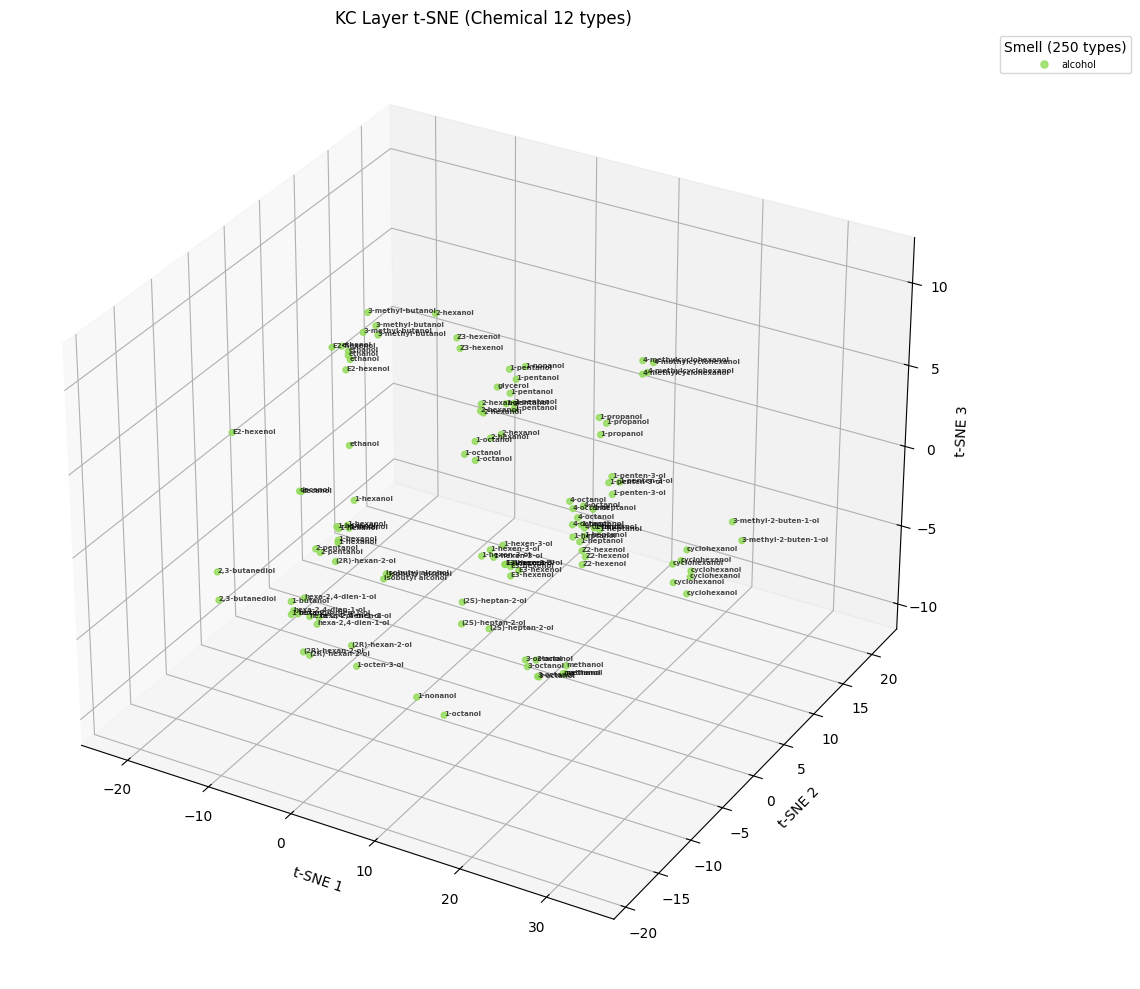

In [ ]:
# plot t-sne with individual className
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

selected_classes = ['alcohol']
for i, ctype in enumerate(le.classes_):
    mask = (smell_labels == i)
    if ctype in selected_classes:
        ax.scatter( # Use ax.scatter for 3D plots
        kc_tsne[mask, 0], kc_tsne[mask, 1], kc_tsne[mask,2], # Added comma here
        s=18, color=palette[i], label= ctype, alpha=0.8
    )

  # 예시 smell class
for i, smtype in enumerate(le.classes_):
    mask = (smell_labels == i)
    if smtype in selected_classes:
        for idx in np.where(mask)[0]:
            ax.text(
                kc_tsne[idx, 0],
                kc_tsne[idx, 1],
                kc_tsne[idx, 2],
                original_data.iloc[y_train[idx],0],
                fontweight='bold' ,fontsize=5, alpha=0.7
            )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3') # Added z-label for 3D plot
plt.title('KC Layer t-SNE (Chemical 12 types)')
ax.legend(
    bbox_to_anchor=(1.04, 1), loc='upper left',
    title='Smell (250 types)', fontsize=7, markerscale=1.2, ncol=4
)
plt.tight_layout()
plt.show()

NameError: name 'KC_output_relu' is not defined

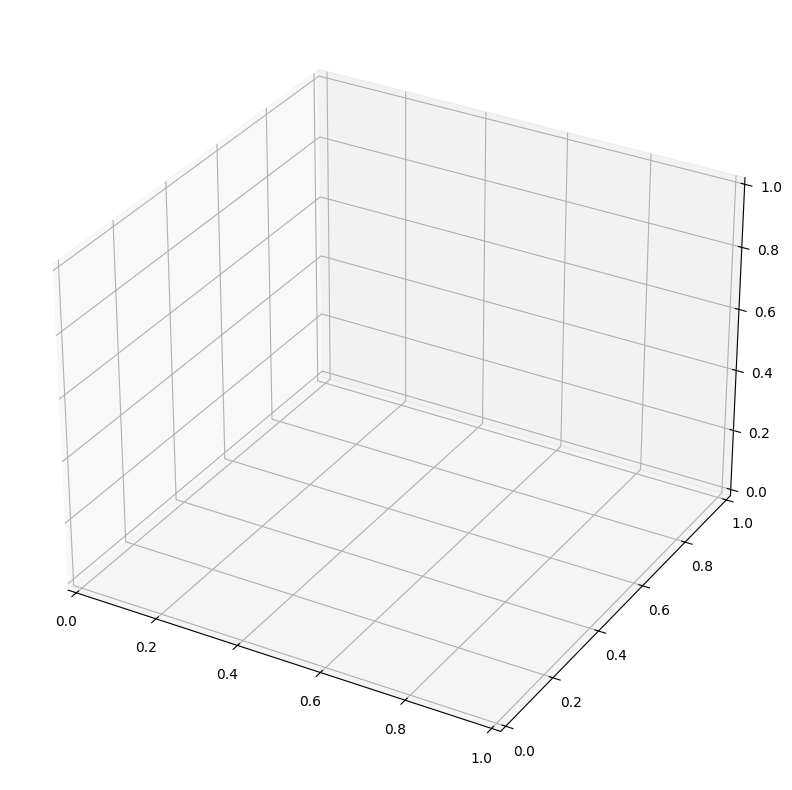

In [ ]:
# chemical type kc output entire t-sne
# original_data=pd.read_csv('door_imputed_same_perOSN_dist.csv') #첫번째열 index로 하고싶으면 해야됨 첫번째행은 자동으로 인덱스 지정해주지만 열은 안해줌
# door=original_data.fillna('other')
# features = kc_relu_df.values
# #smell_names = kc_df.index.values

# smell_types = []
# for i in y_train:
#     smell_types.append(door.iloc[i]['className'])

# le = LabelEncoder()
# smell_labels = le.fit_transform(smell_types)
# n_smells = len(le.classes_)

# Since this is a 3D plot, n_components should be 3
# kc_tsne = TSNE(n_components=3, random_state=42).fit_transform(features)
# palette = sns.color_palette('hls', n_colors=n_smells)

# Need a 3D projection for the plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')


# Use the KC output from the training data and corresponding labels
features_train = KC_output_relu # This should be from cell HpQvkMjcASJE and have 1000 samples
labels_train = smell_labels # This should be from cell eGAzDBKXLab6 or Ya7dwQEfcfVw and have 1000 samples

le_train = LabelEncoder()
smell_labels_encoded = le_train.fit_transform(labels_train)
n_smells_train = len(le_train.classes_)

kc_tsne = TSNE(n_components=3, random_state=42).fit_transform(features_train)
palette_train = sns.color_palette('hls', n_colors=n_smells_train)


for i, ctype in enumerate(le_train.classes_):
    mask = (smell_labels_encoded == i)
    ax.scatter( # Use ax.scatter for 3D plots
        kc_tsne[mask, 0], kc_tsne[mask, 1], kc_tsne[mask,2], # Added comma here
        s=18, color=palette_train[i], label= ctype, alpha=0.8
    )



ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3') # Added z-label for 3D plot
plt.title('KC Layer t-SNE (Chemical 12 types)')
ax.legend(
    bbox_to_anchor=(1.04, 1), loc='upper left',
    title='Smell (250 types)', fontsize=7, markerscale=1.2, ncol=4
)
plt.tight_layout()
plt.show()

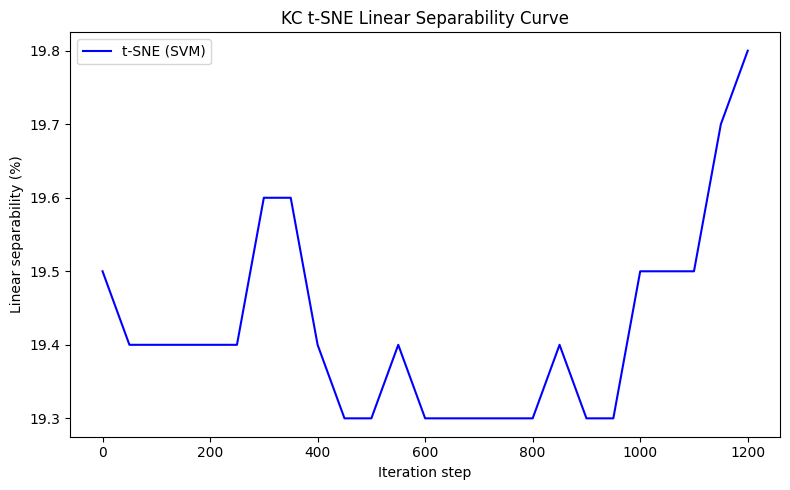

In [ ]:
from openTSNE import TSNE


# Snapshot 저장용 리스트

snapshots = []

def save_intermediate(iteration, error,embedding):
    # embedding을 복사해서 snapshot 리스트에 저장
    snapshots.append(np.copy(embedding))
    return 0  # 계속 진행


tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    callbacks=save_intermediate,
    callbacks_every_iters=50,  # 50 iteration마다 snapshot 저장
    random_state=42
)

final_embedding = tsne.fit(features)

# =============================
# Step별 separability 계산
# =============================
separability_list = []

for emb in snapshots:
    clf = SVC(kernel='linear')
    scores = cross_val_score(clf, emb, smell_labels, cv=5)
    separability = scores.mean() * 100
    separability_list.append(separability)

# =============================
# Curve plot
# =============================
steps = np.arange(len(separability_list)) * 50  # 50 iteration마다 snapshot

plt.figure(figsize=(8, 5))
plt.plot(steps, separability_list, label='t-SNE (SVM)', color='blue')
plt.xlabel('Iteration step')
plt.ylabel('Linear separability (%)')
plt.title('KC t-SNE Linear Separability Curve')
plt.legend()
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklea

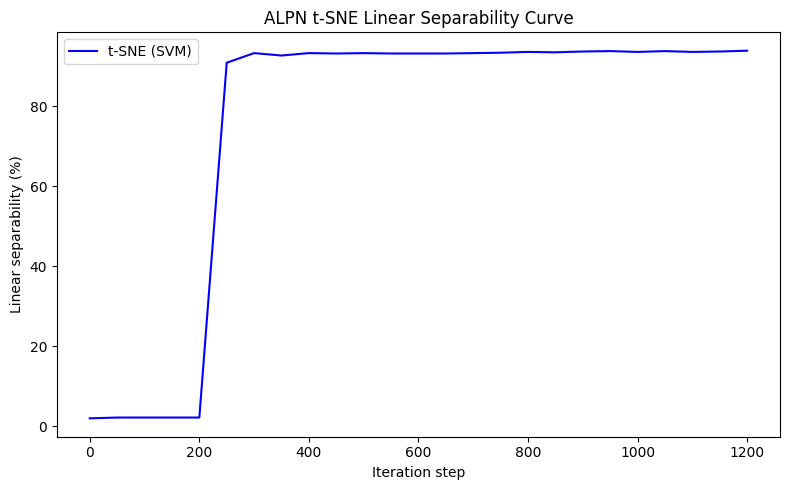

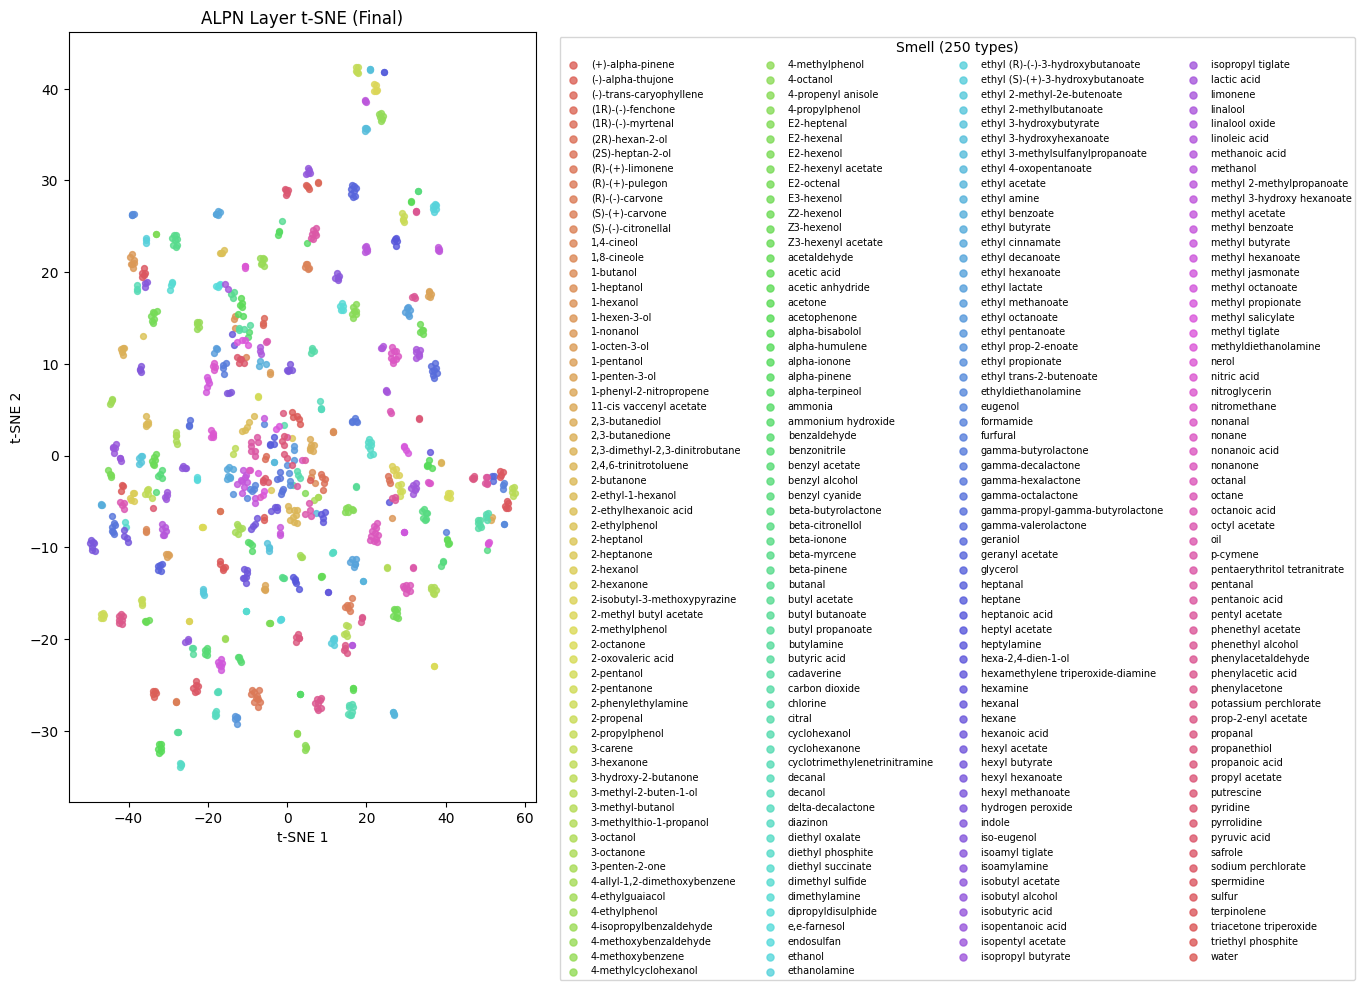

In [ ]:
features = alpn_relu_df.values
smell_names = alpn_relu_df.index.values

le = LabelEncoder()
smell_labels = le.fit_transform(smell_names)
n_smells = len(le.classes_)

# Snapshot 저장용 리스트

snapshots = []

def save_intermediate(iteration, error,embedding):
    # embedding을 복사해서 snapshot 리스트에 저장
    snapshots.append(np.copy(embedding))
    return 0  # 계속 진행


tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    callbacks=save_intermediate,
    callbacks_every_iters=50,  # 50 iteration마다 snapshot 저장
    random_state=42
)

final_embedding = tsne.fit(features)

# =============================
# Step별 separability 계산
# =============================
separability_list = []

for emb in snapshots:
    clf = SVC(kernel='linear')
    scores = cross_val_score(clf, emb, smell_labels, cv=5)
    separability = scores.mean() * 100
    separability_list.append(separability)

# =============================
# Curve plot
# =============================
steps = np.arange(len(separability_list)) * 50  # 50 iteration마다 snapshot

plt.figure(figsize=(8, 5))
plt.plot(steps, separability_list, label='t-SNE (SVM)', color='blue')
plt.xlabel('Iteration step')
plt.ylabel('Linear separability (%)')
plt.title('ALPN t-SNE Linear Separability Curve')
plt.legend()
plt.tight_layout()
plt.show()

# =============================
# 최종 embedding 시각화
# =============================
palette = sns.color_palette('hls', n_colors=n_smells)

plt.figure(figsize=(14, 10))
for i, smell in enumerate(le.classes_):
    mask = (smell_labels == i)
    plt.scatter(
        final_embedding[mask, 0], final_embedding[mask, 1],
        s=18, color=palette[i], label=smell, alpha=0.8
    )

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('ALPN Layer t-SNE (Final)')
plt.legend(
    bbox_to_anchor=(1.04, 1), loc='upper left',
    title='Smell (250 types)', fontsize=7, markerscale=1.2, ncol=4
)
plt.tight_layout()
plt.show()

# Weight comparison

In [ ]:
#100epoch후 weight 추출

#index만들기
otp_ids = mask_otp_norm.index
alpn_ids=mask_otp_norm.columns
kc_ids = mask_ptk_norm.columns

#추출
final_w1 = torch.abs(model.net[0].weight) * model.net[0].mask
final_w2 = torch.abs(model.net[2].weight) * model.net[2].mask
final_w3 = model.net[4].weight


#파일형식 변환
final_w1_np = final_w1.cpu().detach().numpy()
final_w2_np = final_w2.cpu().detach().numpy()
final_w3_np = final_w3.cpu().detach().numpy()

#데이터프레임으로 변환
final_otp = pd.DataFrame(final_w1_np)
final_ptk = pd.DataFrame(final_w2_np)
final_out = pd.DataFrame(final_w3_np)

print(final_otp.shape)
print(final_ptk.shape)
print(final_out.shape)
#csv
#df_w1.to_csv("final_otp.csv", index=True)
#df_w2.to_csv("final_ptk.csv", index=True)

(615, 2278)
(4907, 615)
(250, 4907)


In [ ]:
first_w3 = model.net[4].weight
first_w3_np = first_w3.cpu().detach().numpy()
first_out = pd.DataFrame(first_w3_np)
print(final_out.shape)

(250, 4907)


In [ ]:
#비교를 위해 mask origin도 정규화
mask_otp_origin_n = normalize_by_max_(mask_otp_origin.values.flatten())
mask_ptk_origin_n = normalize_by_max_(mask_ptk_origin.values.flatten())

/tmp/ipython-input-26-1491127444.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dif_mask = otp_random_origin.cpu().detach().flatten() - final_otp.values.flatten()


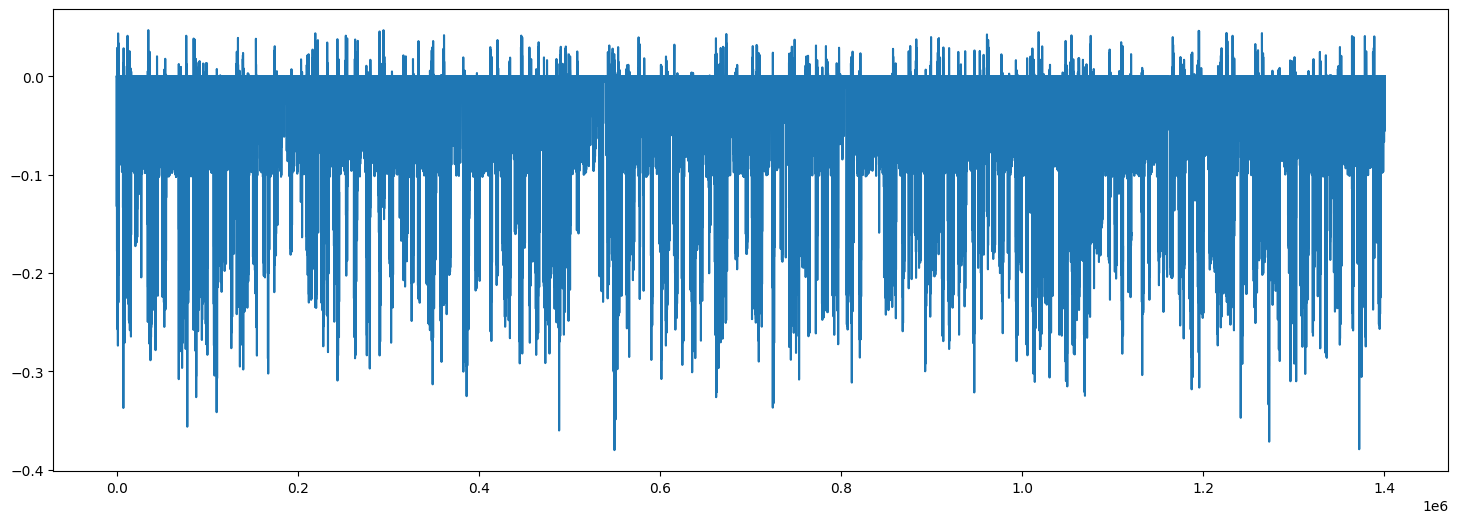

In [ ]:
#otp 차이 시각화
dif_mask = otp_random_origin.cpu().detach().flatten() - final_otp.values.flatten()
plt.figure(figsize=(18, 6))
plt.plot(dif_mask)
plt.show()

In [ ]:
#ptk 차이 시각화
dif1_mask = ptk_origin_random.cpu().detach().flatten() - final_ptk.values.flatten()
plt.figure(figsize=(18, 6))
plt.plot(dif1_mask)
plt.show()

NameError: name 'ptk_origin_random' is not defined

In [ ]:
otp_random_origin = otp_random_origin.cpu().detach()
ptk_random_origin = ptk_random_origin.cpu().detach()

In [ ]:
otp_random_origin.max().max()

tensor(0.0513, device='cuda:0')

In [ ]:
# otp correlation
otp_mask = (mask_otp_origin.values.flatten() != 0)
c_o=otp_random_origin.flatten()[otp_mask]
f_o=final_otp.values.flatten()[otp_mask]
corr_otp = pd.Series(c_o).corr(pd.Series(f_o))
print("orn to alpn correlation :", corr_otp)

orn to alpn correlation : 0.9991801135386746


In [ ]:
print(len(otp_random_origin.flatten()))

1400970


In [ ]:
print(len(c_o))

26239


In [ ]:
# ptk correlation
ptk_mask = (mask_ptk_origin.values.flatten() != 0)
c_p=ptk_random_origin.flatten()[ptk_mask]
f_p=final_ptk.values.flatten()[ptk_mask]
corr_ptk = pd.Series(c_p).corr(pd.Series(f_p))
print("alpn to kc correlation:", corr_ptk)

alpn to kc correlation: 0.997990124012186


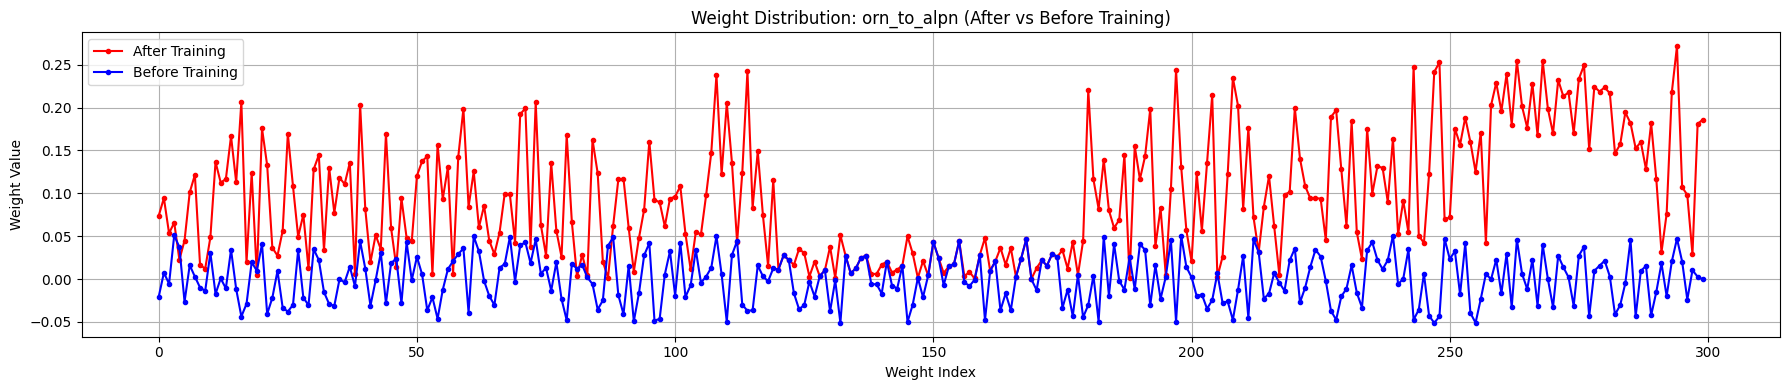

In [ ]:
#otp 그래프비교
otp_mask = (mask_otp_origin.values.flatten() != 0)
c_o = otp_random_origin.flatten()[otp_mask]
f_o = final_otp.values.flatten()[otp_mask]

N = 300
x = range(N)

plt.figure(figsize=(18, 4))
plt.plot(x, f_o[:N], marker='o', linestyle='-', markersize=3, color='red', label='After Training')
plt.plot(x, c_o[:N], marker='o', linestyle='-', markersize=3, color='blue', label='Before Training')
plt.xlabel("Weight Index")
plt.ylabel("Weight Value")
plt.title("Weight Distribution: orn_to_alpn (After vs Before Training)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

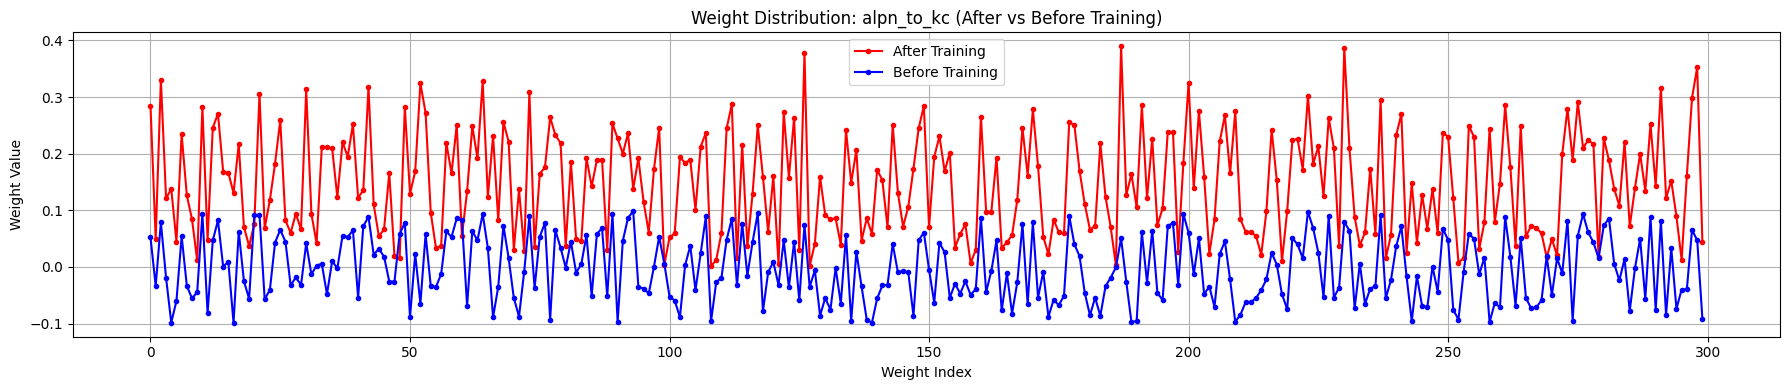

In [ ]:
#ptk 그래프비교
ptk_mask = (mask_ptk_origin.values.flatten() != 0)
c_o = ptk_random_origin.flatten()[ptk_mask]
f_o = final_ptk.values.flatten()[ptk_mask]

N = 300
x = range(N)

plt.figure(figsize=(18, 4))
plt.plot(x, f_o[:N], marker='o', linestyle='-', markersize=3, color='red', label='After Training')
plt.plot(x, c_o[:N], marker='o', linestyle='-', markersize=3, color='blue', label='Before Training')
plt.xlabel("Weight Index")
plt.ylabel("Weight Value")
plt.title("Weight Distribution: alpn_to_kc (After vs Before Training)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()